In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector

import plotly.express as px
import seaborn as sns
sns.set_theme(context='notebook', style='whitegrid', palette='muted')

import math

In [2]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [4]:
data = pd.read_csv("train.csv", sep=',', engine='python')
data.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

## NULL Werte

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
data.isnull().sum()

d = {
    'Column': data.isnull().sum().index,
    'Num Nulls': data.isnull().sum().values,
    '% Nulls': ((data.isnull().sum().values / data.shape[0]) * 100).round(2)}
nulls_df = pd.DataFrame(data=d)

nulls_df

Column  Num Nulls  % Nulls
0    PassengerId          0     0.00
1     HomePlanet        201     2.31
2      CryoSleep        217     2.50
3          Cabin        199     2.29
4    Destination        182     2.09
5            Age        179     2.06
6            VIP        203     2.34
7    RoomService        181     2.08
8      FoodCourt        183     2.11
9   ShoppingMall        208     2.39
10           Spa        183     2.11
11        VRDeck        188     2.16
12          Name        200     2.30
13   Transported          0     0.00

In [7]:
tmp = data.loc[data['HomePlanet'].isnull(), ['Transported']].groupby('Transported').size()
tmp[True]

103

In [8]:
##  Verteilung der unbekannten Werte in Abhängigkeit vom Wert der Zielvariablen

columns=[]
transported=[]
not_transported=[]

for col in data.columns:
    if data[col].isnull().sum() > 0:
        tmp = data.loc[data[col].isnull(), ['Transported']].groupby('Transported').size()
        columns.append(col)
        transported.append(round(tmp[True] / tmp.values.sum() * 100, 2))
        not_transported.append(round(tmp[False] / tmp.values.sum() * 100, 2))

d = {'Columns' : columns, 'transported %' : transported, 'not_transported %': not_transported }   

null_distrib_df = pd.DataFrame(data=d)

null_distrib_df

Columns  transported %  not_transported %
0     HomePlanet          51.24              48.76
1      CryoSleep          48.85              51.15
2          Cabin          50.25              49.75
3    Destination          50.55              49.45
4            Age          50.28              49.72
5            VIP          51.23              48.77
6    RoomService          45.86              54.14
7      FoodCourt          54.10              45.90
8   ShoppingMall          54.81              45.19
9            Spa          49.73              50.27
10        VRDeck          52.13              47.87
11          Name          50.50              49.50

In [9]:
# nulls in Zeilen
tmp = data.isnull().sum(axis=1)
nulls_in_rows = pd.DataFrame(data = {'row' : tmp.index, 'null_num' : tmp.values})
nulls_in_rows.groupby('null_num', as_index=False).size()

null_num  size
0         0  6606
1         1  1867
2         2   203
3         3    17

In [10]:
# Zeile mit nulls anschauen
data.iloc[data.isnull().sum(axis=1).gt(0).values, :]
# -- 2087 Zeilen haben mindestens 1 Null Wert (bis 3 Null Werte)

PassengerId HomePlanet CryoSleep     Cabin  Destination   Age    VIP  \
7        0006_02      Earth      True     G/0/S  TRAPPIST-1e  28.0  False   
10       0008_02     Europa      True     B/1/P  TRAPPIST-1e  34.0  False   
15       0012_01      Earth     False       NaN  TRAPPIST-1e  31.0  False   
16       0014_01       Mars     False     F/3/P  55 Cancri e  27.0  False   
23       0020_03      Earth      True     E/0/S  55 Cancri e  29.0  False   
...          ...        ...       ...       ...          ...   ...    ...   
8667     9250_01     Europa     False   E/597/P  TRAPPIST-1e  29.0  False   
8674     9257_01        NaN     False  F/1892/P  TRAPPIST-1e  13.0  False   
8675     9259_01      Earth       NaN  F/1893/P  TRAPPIST-1e  44.0  False   
8684     9274_01        NaN      True  G/1508/P  TRAPPIST-1e  23.0  False   
8687     9275_03     Europa       NaN    A/97/P  TRAPPIST-1e  30.0  False   

      RoomService  FoodCourt  ShoppingMall   Spa  VRDeck                Name  \
7             0.0        0.0           0.0   0.0     NaN  Candra Jacostaffey   
10            0.0        0.0           NaN   0.0     0.0      Altardr Flatic   
15           32.0        0.0         876.0   0.0     0.0       Justie Pooles   
16         1286.0      122.0           NaN   0.0     0.0         Flats Eccle   
23            0.0        0.0           NaN   0.0     0.0  Mollen Mcfaddennon   
...           ...        ...           ...   ...     ...                 ...   
8667          0.0     2972.0           NaN  28.0   188.0    Chain Reedectied   
8674         39.0        0.0        1085.0  24.0     0.0          Ties Apple   
8675       1030.0     1015.0           0.0  11.0     NaN     Annah Gilleyons   
8684          0.0        0.0           0.0   0.0     0.0     Chelsa Bullisey   
8687          0.0     3208.0           0.0   2.0   330.0     Atlasym Conable   

      Transported  
7            True  
10           True  
15          False  
16          False  
23          False  
...           ...  
8667         True  
8674        False  
8675         True  
8684         True  
8687         True  

[2087 rows x 14 columns]

In [11]:
category_features = data.select_dtypes(include="object").columns

for c in category_features:
    if c != 'name':
        print(f"Spalte: '{c}'",)
        print(data.loc[:, c].unique())

Spalte: 'PassengerId'
['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02']
Spalte: 'HomePlanet'
['Europa' 'Earth' 'Mars' nan]
Spalte: 'CryoSleep'
[False True nan]
Spalte: 'Cabin'
['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']
Spalte: 'Destination'
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
Spalte: 'VIP'
[False True nan]
Spalte: 'Name'
['Maham Ofracculy' 'Juanna Vines' 'Altark Susent' ... 'Fayey Connon'
 'Celeon Hontichre' 'Propsh Hontichre']


## Data Visualisierung

In [12]:
for_visual_df = data.copy()

### Neue Features erzeugen

    --> Cabin: 'CabinDeck', 'CabinNum', 'CabinSide'

In [13]:
for_visual_df[['CabinDeck', 'CabinNum', 'CabinSide']] = for_visual_df['Cabin'].str.split('/', expand=True)

    --> PassengerId: 'GroupId', 'NumInGroup'

In [14]:
for_visual_df[['GroupId', 'NumInGroup']] = for_visual_df['PassengerId'].str.split('_', expand=True)

    --> 'GroupSize'

In [15]:
GroupSize_df = for_visual_df.groupby('GroupId', as_index=False).agg(
                                    GroupSize = ('PassengerId', 'count'))
    

for_visual_df = for_visual_df.merge(GroupSize_df, how='left', left_on='GroupId', right_on='GroupId')
for_visual_df.head(5)

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported CabinDeck CabinNum CabinSide GroupId NumInGroup  GroupSize  
0        False         B        0         P    0001         01          1  
1         True         F        0         S    0002         01          1  
2        False         A        0         S    0003         01          2  
3        False         A        0         S    0003         02          2  
4         True         F        1         S    0004         01          1

In [16]:
for_visual_df['TotalSpend'] = for_visual_df.loc[:,
                        ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

    --> 'HomePlanet' + 'Destination' = 'Route'

In [17]:
for_visual_df['Route'] = for_visual_df['HomePlanet'] + ' - ' +for_visual_df['Destination']

In [18]:
for_visual_df['CabinNum'] = for_visual_df.loc[:,'CabinNum'].astype(float) 
for_visual_df['GroupId'] = for_visual_df.loc[:,'GroupId'].astype(float) 

In [19]:
for_visual_df[['FirstName', 'LastName']] = for_visual_df['Name'].str.split(' ', expand=True)

In [20]:
for_visual_df.groupby(['GroupId'],as_index=False).agg(cabins=('CabinNum', lambda x: len(x.unique()))).sort_values('cabins', ascending=False)

GroupId  cabins
1388   2092.0     4.0
5459   8129.0     4.0
1132   1709.0     4.0
5814   8668.0     3.0
2611   3911.0     3.0
...       ...     ...
2155   3217.0     1.0
2153   3215.0     1.0
2152   3213.0     1.0
2151   3212.0     1.0
6216   9280.0     1.0

[6217 rows x 2 columns]

In [21]:
for_visual_df['IsSingle'] = for_visual_df.loc[:, 'GroupSize'].apply(lambda x: x==1 )

In [22]:
for_visual_df['NoSpend'] = for_visual_df.loc[:, 'TotalSpend'].apply(lambda x: np.nan if math.isnan(x) else x==0)

In [23]:
for_visual_df['IsChild'] = for_visual_df.loc[:, 'Age'] <= 18

In [24]:
# 1. число однофамильцев в группе
namesakes_in_group_df = for_visual_df.groupby(['LastName', 'GroupId'], as_index=False).agg(
                namesakes_num_in_group = ('PassengerId', 'count'))

for_visual_df = for_visual_df.merge(
    namesakes_in_group_df, how='left',
    left_on=['LastName', 'GroupId'],
    right_on=['LastName', 'GroupId'])

for_visual_df['namesakes_num_in_group'] = for_visual_df['namesakes_num_in_group'] - 1

In [25]:
# #2. число разных фамилий в группе
# namesakes_in_group_df = for_visual_df.groupby(['GroupId'], as_index=False).agg(
#                 namesakes_num_in_group = ('LastName', lambda x: len(x.unique())))

# for_visual_df = for_visual_df.merge(namesakes_in_group_df,
#                                     how='left',
#                                     left_on=['LastName', 'GroupId'],
#                                     right_on=['LastName', 'GroupId'])

# for_visual_df['namesakes_num_in_group'] = for_visual_df['namesakes_num_in_group'] - 1

In [26]:
# #3. число кабин с однофамильцами
# cabins_with_namesakes_df = namesakes_in_cabin_df.groupby(['LastName'], as_index=False).agg(
#                     cabins_num_with_namesakes = ('CabinNum', 'count'))

# for_visual_df = for_visual_df.merge(cabins_with_namesakes_df, how='left', left_on='LastName', right_on='LastName')
# for_visual_df['cabins_num_with_namesakes'] = for_visual_df['cabins_num_with_namesakes'] - 1

In [27]:
for_visual_df['NameLength'] = for_visual_df.loc[:, 'Name'].str.len()

In [28]:
for_visual_df.head(10)

PassengerId HomePlanet CryoSleep  Cabin    Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P    TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S    TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S    TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S    TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S    TRAPPIST-1e  16.0  False   
5     0005_01      Earth     False  F/0/P  PSO J318.5-22  44.0  False   
6     0006_01      Earth     False  F/2/S    TRAPPIST-1e  26.0  False   
7     0006_02      Earth      True  G/0/S    TRAPPIST-1e  28.0  False   
8     0007_01      Earth     False  F/3/S    TRAPPIST-1e  35.0  False   
9     0008_01     Europa      True  B/1/P    55 Cancri e  14.0  False   

   RoomService  FoodCourt  ShoppingMall  ...  GroupSize  TotalSpend  \
0          0.0        0.0           0.0  ...          1         0.0   
1        109.0        9.0          25.0  ...          1       736.0   
2         43.0     3576.0           0.0  ...          2     10383.0   
3          0.0     1283.0         371.0  ...          2      5176.0   
4        303.0       70.0         151.0  ...          1      1091.0   
5          0.0      483.0           0.0  ...          1       774.0   
6         42.0     1539.0           3.0  ...          2      1584.0   
7          0.0        0.0           0.0  ...          2         0.0   
8          0.0      785.0          17.0  ...          1      1018.0   
9          0.0        0.0           0.0  ...          3         0.0   

                   Route  FirstName     LastName  IsSingle NoSpend  IsChild  \
0   Europa - TRAPPIST-1e      Maham    Ofracculy      True    True    False   
1    Earth - TRAPPIST-1e     Juanna        Vines      True   False    False   
2   Europa - TRAPPIST-1e     Altark       Susent     False   False    False   
3   Europa - TRAPPIST-1e      Solam       Susent     False   False    False   
4    Earth - TRAPPIST-1e      Willy  Santantines      True   False     True   
5  Earth - PSO J318.5-22     Sandie   Hinetthews      True   False    False   
6    Earth - TRAPPIST-1e     Billex  Jacostaffey     False   False    False   
7    Earth - TRAPPIST-1e     Candra  Jacostaffey     False    True    False   
8    Earth - TRAPPIST-1e     Andona       Beston      True   False    False   
9   Europa - 55 Cancri e    Erraiam       Flatic     False    True     True   

  namesakes_num_in_group  NameLength  
0                    0.0        15.0  
1                    0.0        12.0  
2                    1.0        13.0  
3                    1.0        12.0  
4                    0.0        17.0  
5                    0.0        17.0  
6                    1.0        18.0  
7                    1.0        18.0  
8                    0.0        13.0  
9                    2.0        14.0  

[10 rows x 29 columns]

### Visualisierung von kategorialen Features

([<matplotlib.patches.Wedge at 0x1ad52f51b50>,
 [Text(0.012522008688130899, 1.0999287246446539, 'False'),
  Text(-0.012522008688131034, -1.0999287246446539, 'True')],
 [Text(0.006830186557162308, 0.5999611225334475, '49.6%'),
  Text(-0.006830186557162382, -0.5999611225334475, '50.4%')])

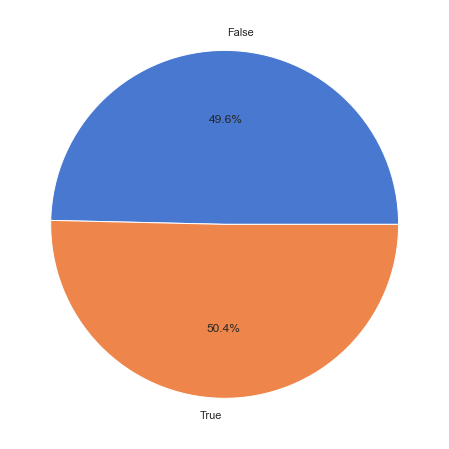

In [29]:
fig, axs = plt.subplots(figsize=(10, 8))
d = for_visual_df.groupby('Transported', as_index=False).size()

axs.pie(d['size'], labels= d['Transported'], autopct='%1.1f%%')

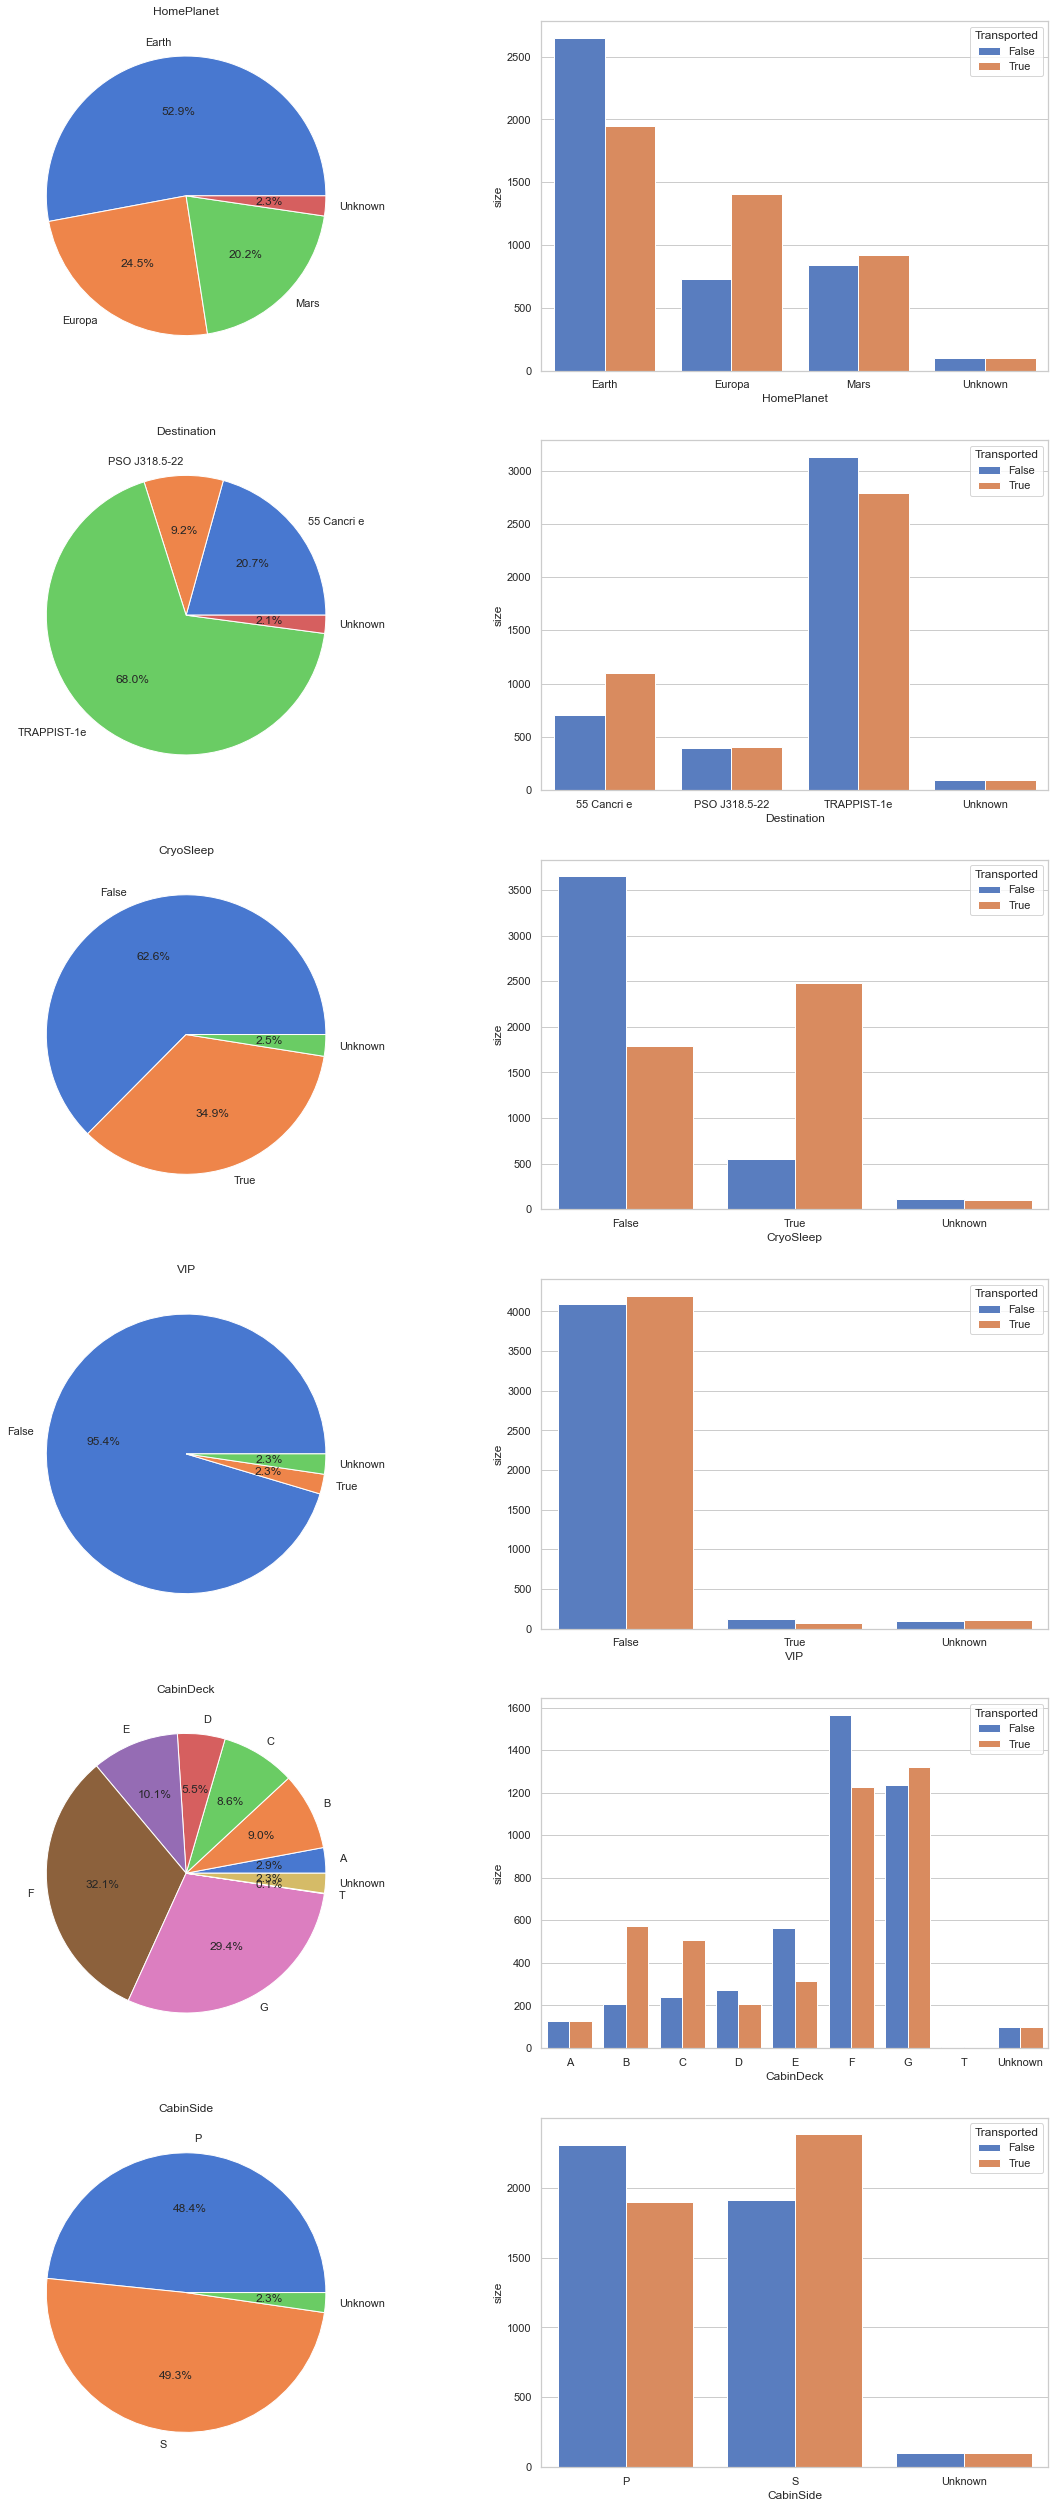

In [30]:
category_features = ['HomePlanet', 'Destination', 'CryoSleep', 'VIP', 'CabinDeck', 'CabinSide']

fig, axs = plt.subplots(6, 2, figsize=(20, 45))
i = 0
axe = axs.ravel()

for f in category_features: #i, f in enumerate(category_features):
    d1 = for_visual_df.groupby(f, as_index=False, dropna=False).size()
    d1= d1.fillna('Unknown')
    axe[i].pie(d1['size'], labels=d1[f], autopct='%1.1f%%')
    axe[i].set_title(f)
    i+=1
    
    d2 = for_visual_df.groupby([f, 'Transported'], as_index=False, dropna=False).size()
    d2= d2.fillna('Unknown')
    sns.barplot(x=f, y="size",
                hue="Transported",
                data=d2, ax=axe[i])
    i+=1


### Visualisierung von numerischen Features

<AxesSubplot:xlabel='RoomService', ylabel='Count'>

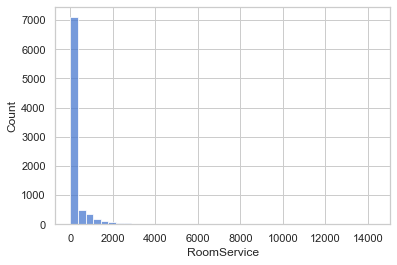

In [31]:
sns.histplot(data=for_visual_df, x='RoomService', bins=40)


In [32]:
num_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' ]

for f in num_features:
    for_visual_df[f+'_log'] = np.log10(for_visual_df[f] + 1)

In [33]:
for_visual_df.head(5)

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall  ...  IsSingle  NoSpend IsChild  \
0          0.0        0.0           0.0  ...      True     True   False   
1        109.0        9.0          25.0  ...      True    False   False   
2         43.0     3576.0           0.0  ...     False    False   False   
3          0.0     1283.0         371.0  ...     False    False   False   
4        303.0       70.0         151.0  ...      True    False    True   

   namesakes_num_in_group NameLength  RoomService_log FoodCourt_log  \
0                     0.0       15.0         0.000000      0.000000   
1                     0.0       12.0         2.041393      1.000000   
2                     1.0       13.0         1.643453      3.553519   
3                     1.0       12.0         0.000000      3.108565   
4                     0.0       17.0         2.482874      1.851258   

   ShoppingMall_log   Spa_log  VRDeck_log  
0          0.000000  0.000000    0.000000  
1          1.414973  2.740363    1.653213  
2          0.000000  3.827111    1.698970  
3          2.570543  3.522444    2.287802  
4          2.181844  2.752816    0.477121  

[5 rows x 34 columns]

<AxesSubplot:xlabel='Age', ylabel='Count'>

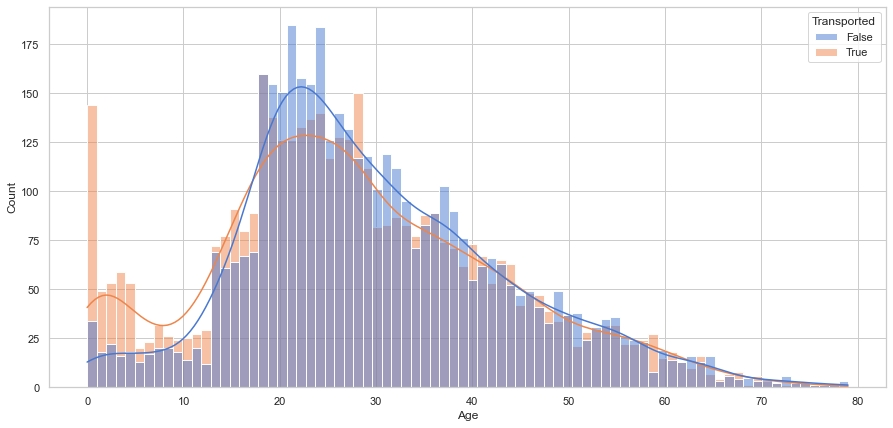

In [34]:
fig, axs = plt.subplots(figsize=(15, 7))
sns.histplot(data=for_visual_df, x='Age', bins=80, hue="Transported", kde=True)


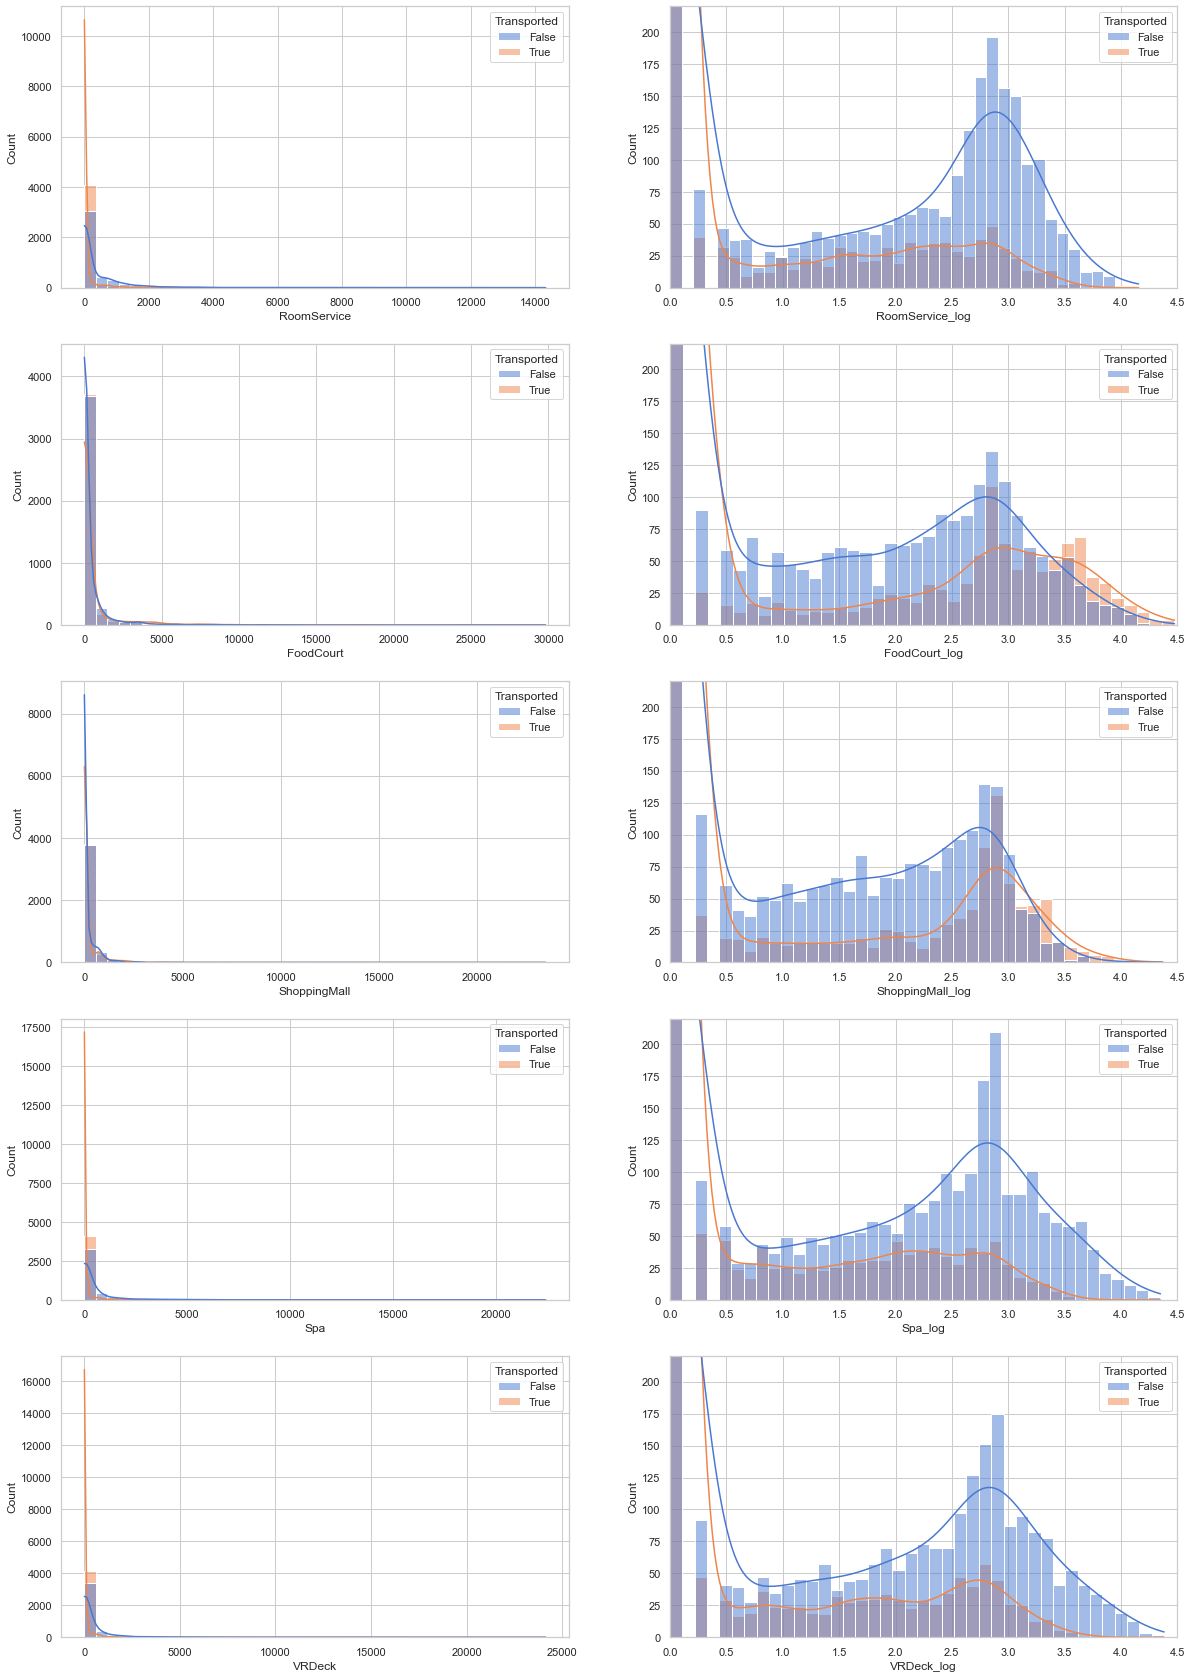

In [35]:

num_features = ['RoomService', 'RoomService_log',
                'FoodCourt', 'FoodCourt_log',
                'ShoppingMall','ShoppingMall_log',
                'Spa', 'Spa_log',
                'VRDeck', 'VRDeck_log' ]

fig, axs = plt.subplots(5, 2, figsize=(20, 30))
axe = axs.ravel()

for i, f in enumerate(num_features):
    sns.histplot(data=for_visual_df, x=f, ax=axe[i], bins=40, hue="Transported", kde=True)
    if i%2:
#        axe[i].set(xscale="log")
        axe[i].set_xlim(0,4.5)
        axe[i].set_ylim(0,220)

<AxesSubplot:xlabel='GroupSize', ylabel='size'>

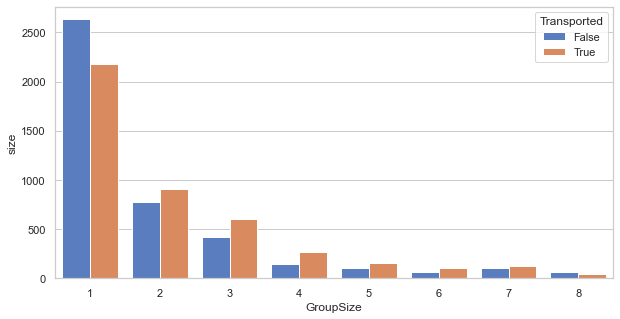

In [36]:
fig, axs = plt.subplots(figsize=(10, 5))
d = for_visual_df.groupby(['GroupSize', 'Transported'], as_index=False, dropna=False).size()

sns.barplot(x='GroupSize', y="size",
                hue="Transported",
                data=d)

<AxesSubplot:xlabel='HomePlanet', ylabel='Destination'>

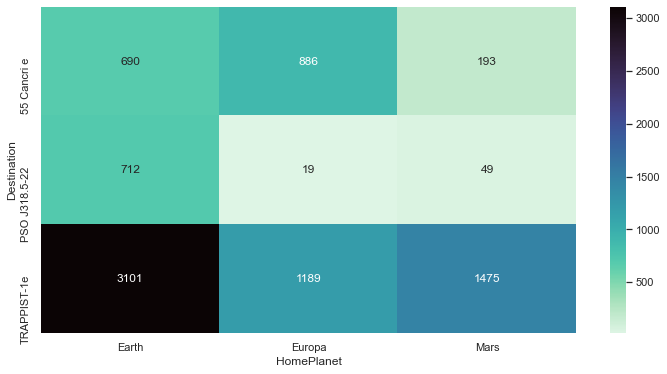

In [37]:
d=for_visual_df.groupby(['Destination', 'HomePlanet']).size().unstack().fillna(0)

fig, axs = plt.subplots(figsize=(12, 6))
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r')

<AxesSubplot:xlabel='size', ylabel='Route'>

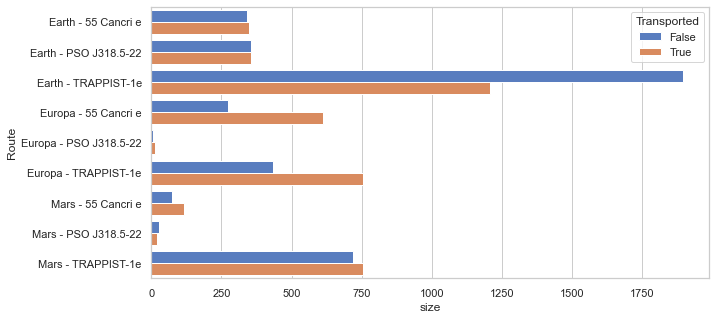

In [38]:
fig, axs = plt.subplots(figsize=(10, 5))

d = for_visual_df.groupby(['Route', 'Transported'], as_index=False).size()

sns.barplot(x='size', y="Route",
                hue="Transported",
                data=d)

<AxesSubplot:xlabel='CabinDeck', ylabel='HomePlanet'>

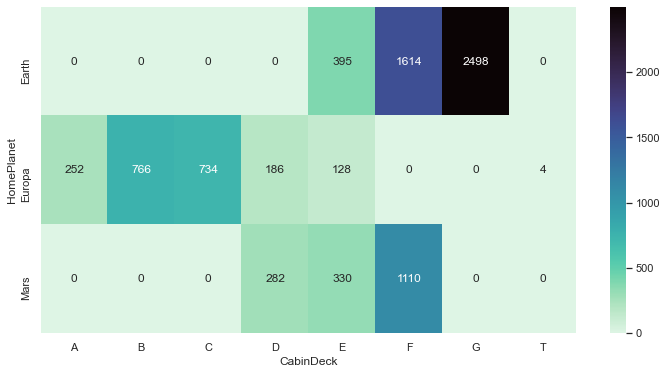

In [39]:
d=for_visual_df.groupby(['HomePlanet', 'CabinDeck']).size().unstack().fillna(0)

fig, axs = plt.subplots(figsize=(12, 6))
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r')

<AxesSubplot:xlabel='CabinDeck', ylabel='Destination'>

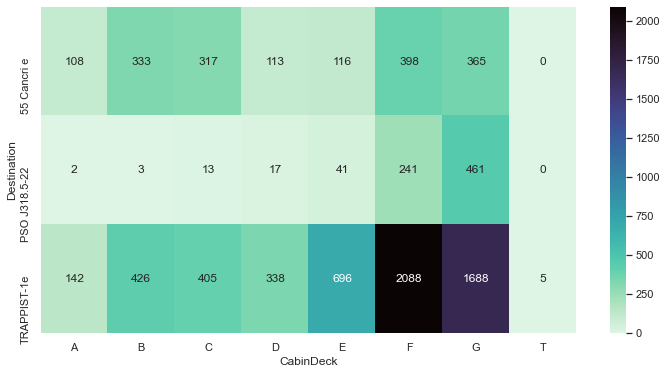

In [40]:
d=for_visual_df.groupby(['Destination', 'CabinDeck']).size().unstack().fillna(0)

fig, axs = plt.subplots(figsize=(12, 6))
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r')

<AxesSubplot:xlabel='CabinDeck', ylabel='Route'>

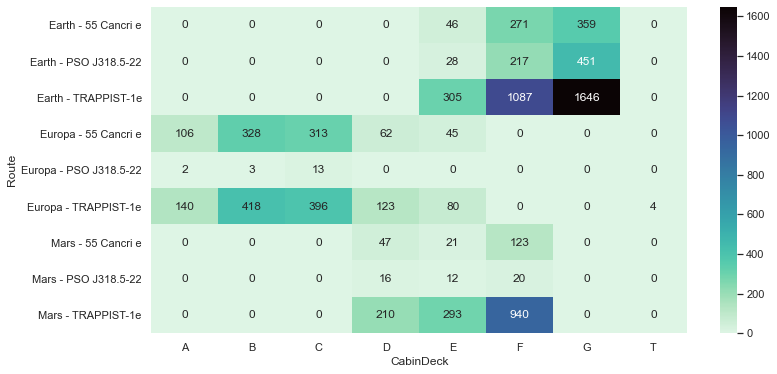

In [41]:
d=for_visual_df.groupby(['Route', 'CabinDeck']).size().unstack().fillna(0)

fig, axs = plt.subplots(figsize=(12, 6))
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r')

In [42]:
for_visual_df.loc[:, ['GroupId', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall',
                                   'Spa', 'VRDeck', 'CabinNum', 'GroupSize', 'TotalSpend']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8693 entries, 0 to 8692
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GroupId       8693 non-null   float64
 1   Age           8514 non-null   float64
 2   RoomService   8512 non-null   float64
 3   FoodCourt     8510 non-null   float64
 4   ShoppingMall  8485 non-null   float64
 5   Spa           8510 non-null   float64
 6   VRDeck        8505 non-null   float64
 7   CabinNum      8494 non-null   float64
 8   GroupSize     8693 non-null   int64  
 9   TotalSpend    8693 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 747.1 KB


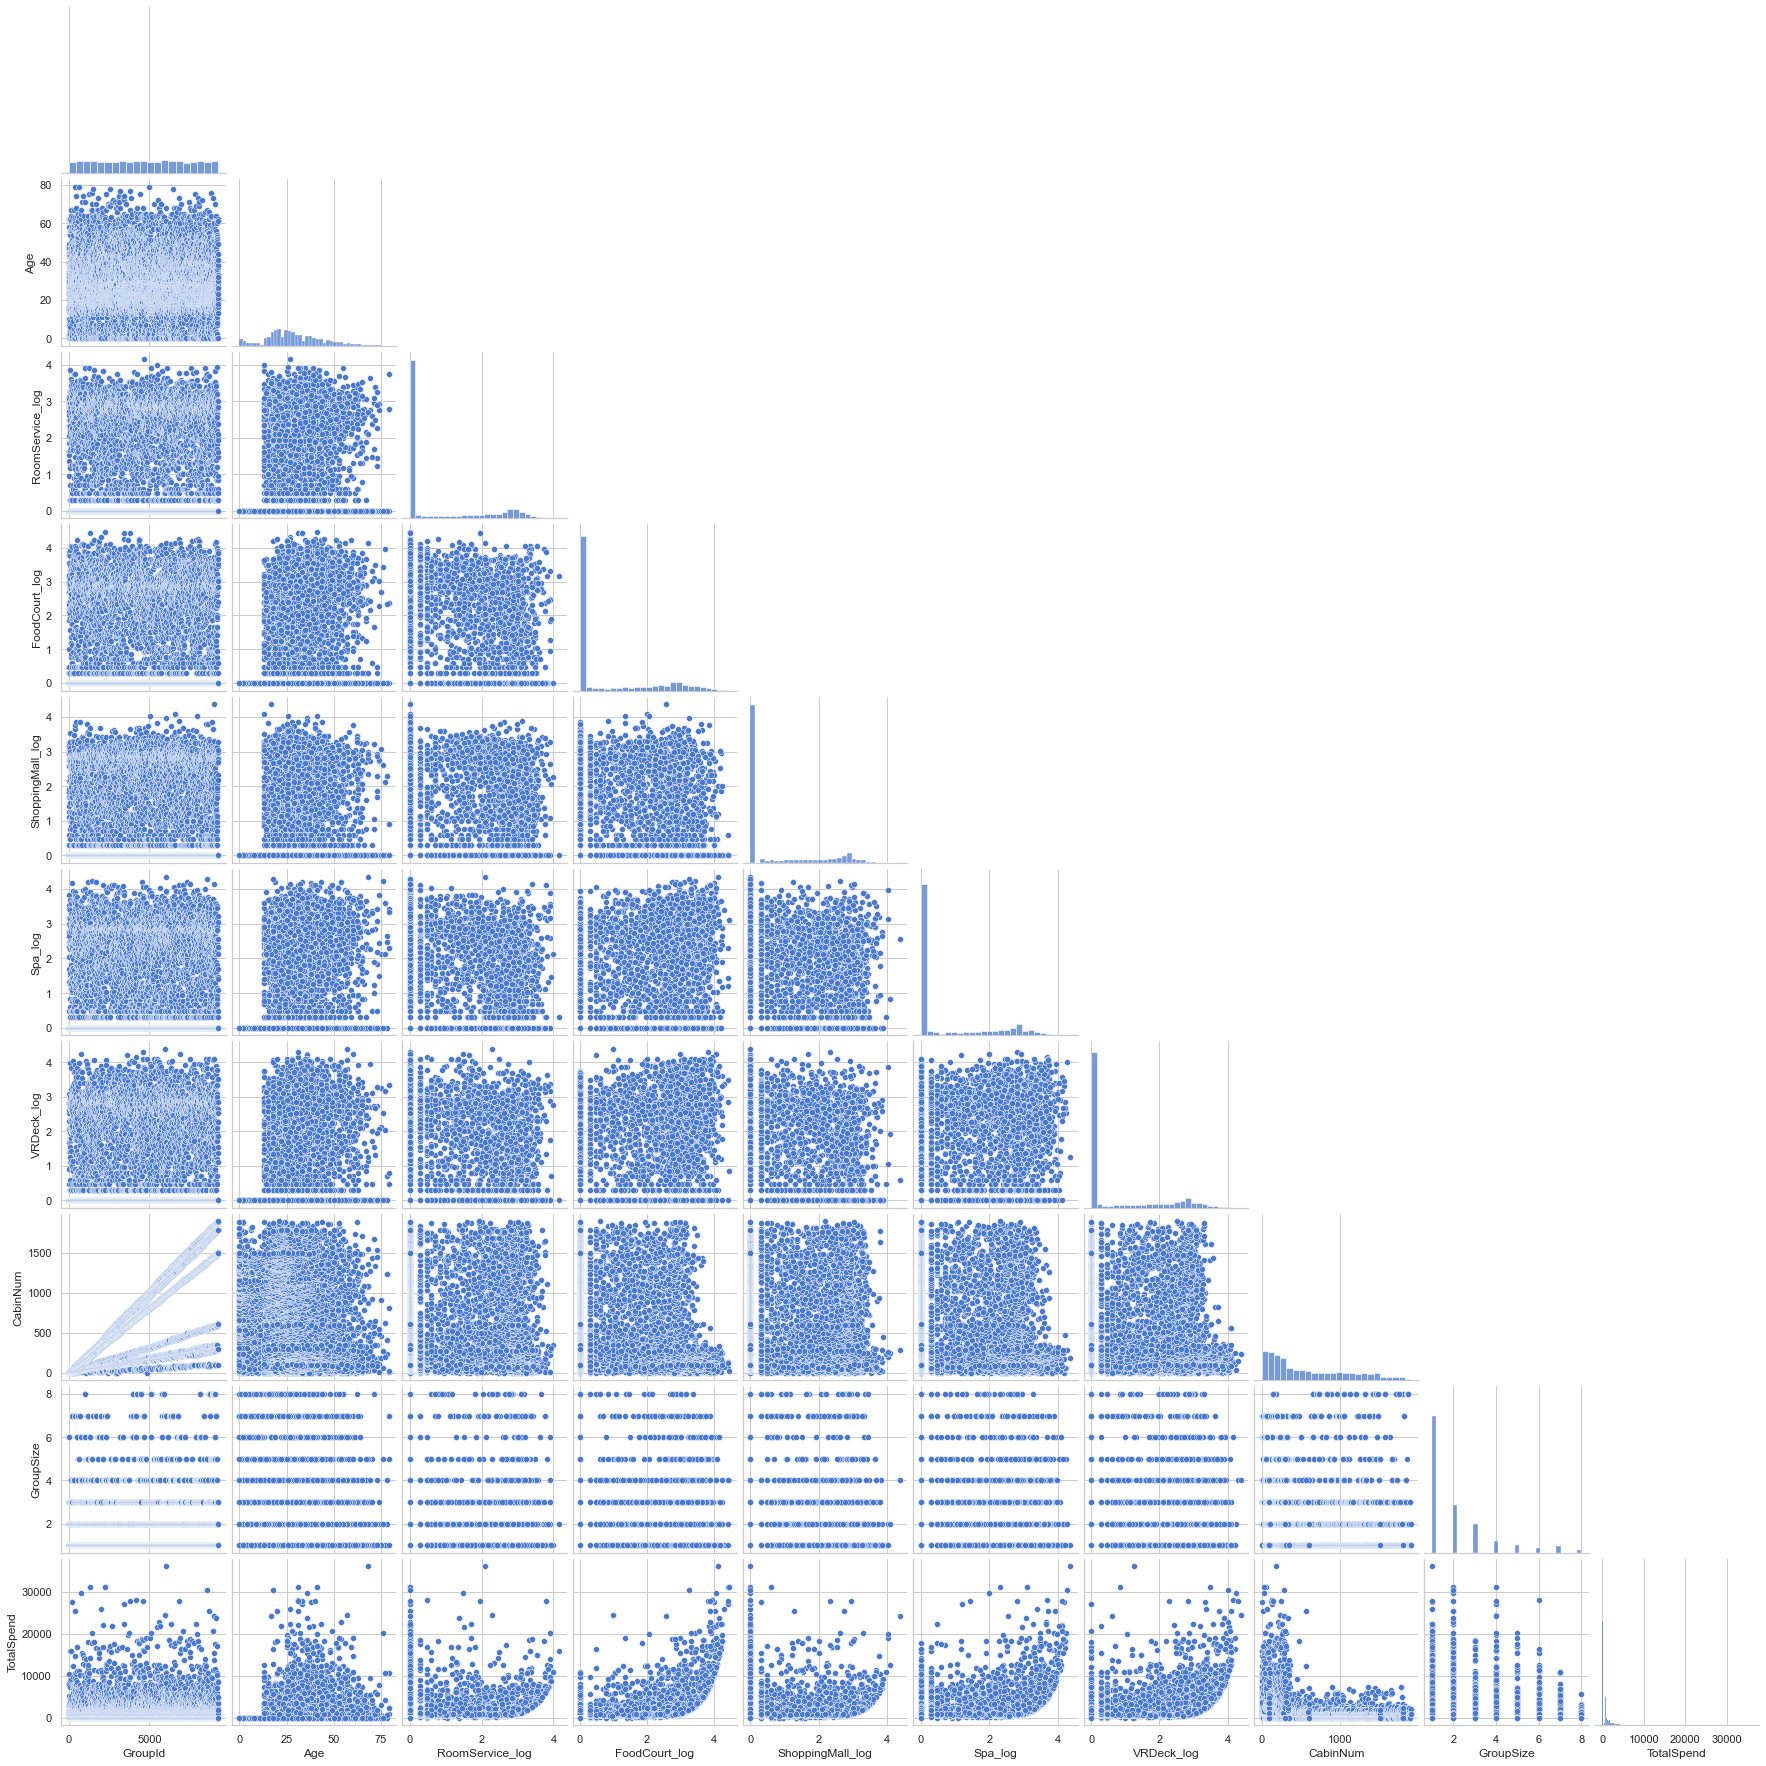

In [43]:
sns.pairplot(for_visual_df.loc[:, ['GroupId', 'Age', 'RoomService_log', 'FoodCourt_log', 'ShoppingMall_log',
                                   'Spa_log', 'VRDeck_log', 'CabinNum', 'GroupSize', 'TotalSpend']],
             corner=True)

<AxesSubplot:xlabel='CabinNum', ylabel='GroupId'>

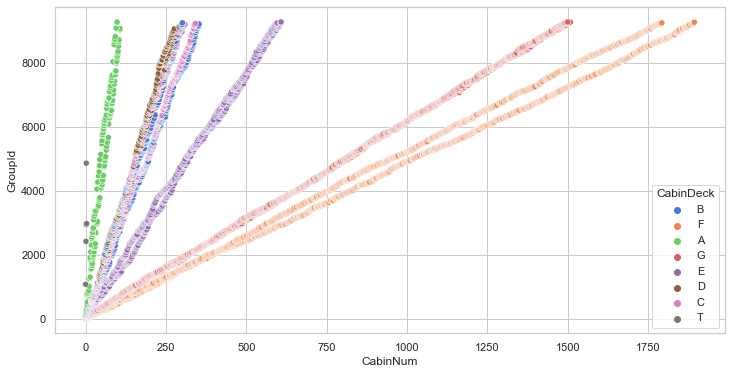

In [44]:
fig, axs = plt.subplots(figsize=(12, 6))

sns.scatterplot(data=for_visual_df, x='CabinNum', y='GroupId', hue='CabinDeck', ax=axs)


<AxesSubplot:xlabel='Age', ylabel='TotalSpend'>

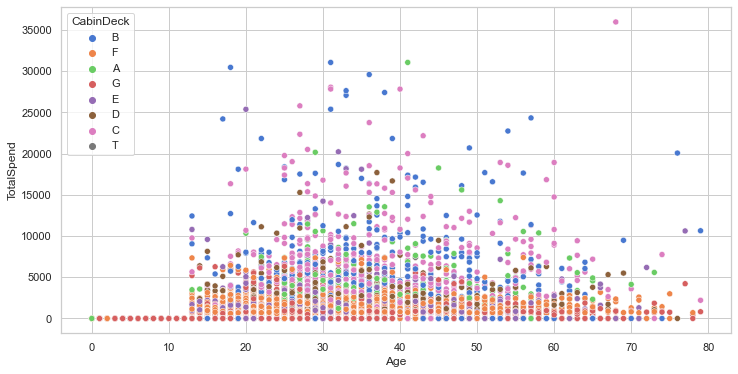

In [45]:
fig, axs = plt.subplots(figsize=(12, 6))

sns.scatterplot(data=for_visual_df,x="Age", y="TotalSpend", hue='CabinDeck',ax=axs)

In [46]:
for_visual_df.loc[for_visual_df['Age'] < 13, ['CabinDeck']].value_counts()

CabinDeck
G            548
F            173
E             23
C             16
B             15
A             12
D              2
dtype: int64

<AxesSubplot:xlabel='NoSpend', ylabel='CryoSleep'>

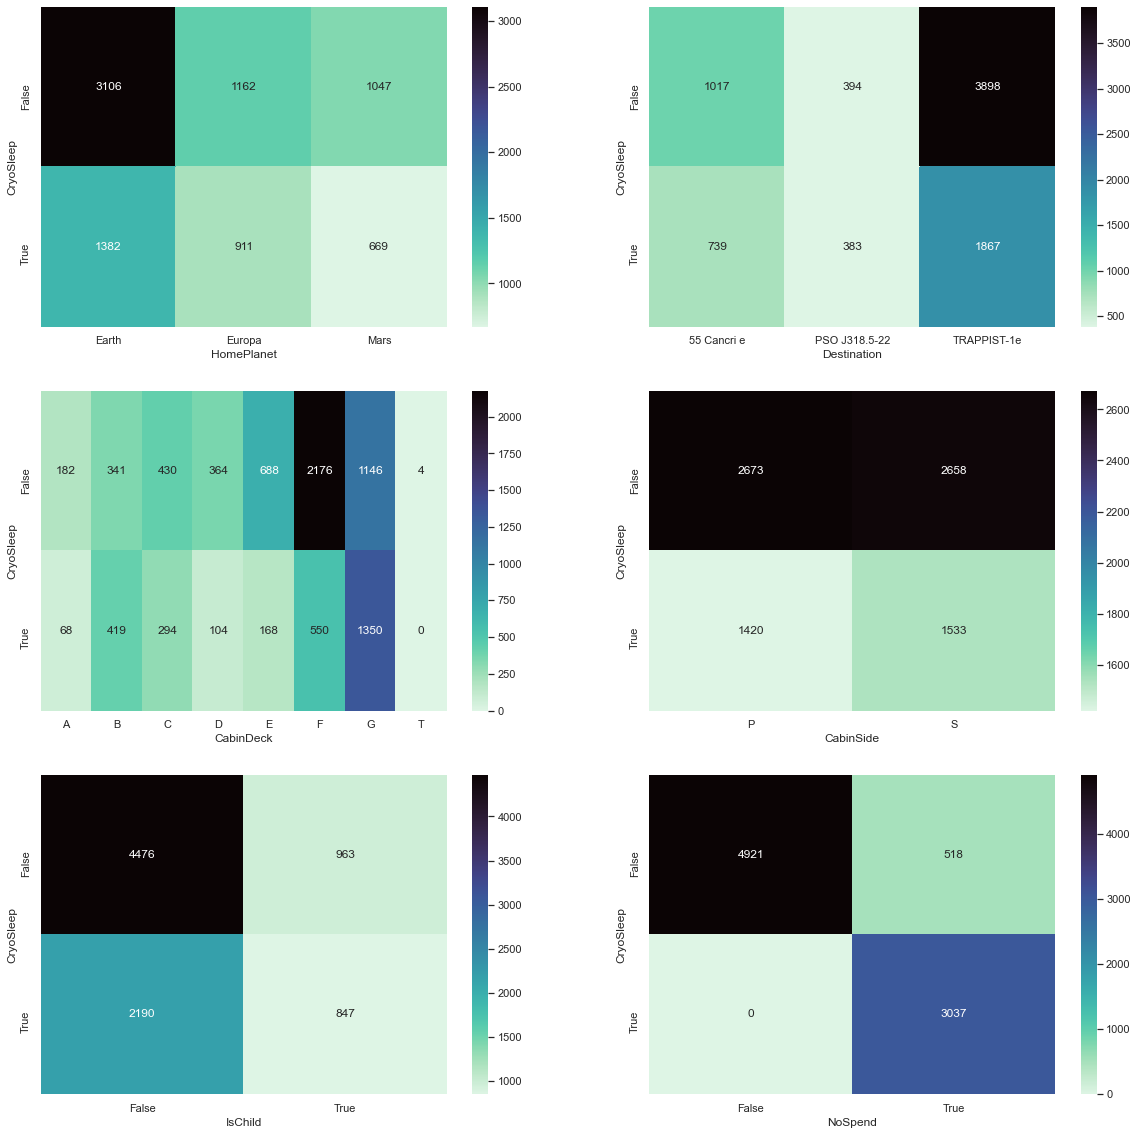

In [47]:
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
axs = axs.ravel()
d=for_visual_df.groupby(['CryoSleep', 'HomePlanet']).size().unstack().fillna(0)
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r', ax=axs[0])

d=for_visual_df.groupby(['CryoSleep', 'Destination']).size().unstack().fillna(0)
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r', ax=axs[1])

d=for_visual_df.groupby(['CryoSleep', 'CabinDeck']).size().unstack().fillna(0)
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r', ax=axs[2])

d=for_visual_df.groupby(['CryoSleep', 'CabinSide']).size().unstack().fillna(0)
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r', ax=axs[3])

d=for_visual_df.groupby(['CryoSleep', 'IsChild']).size().unstack().fillna(0)
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r', ax=axs[4])

d=for_visual_df.groupby(['CryoSleep', 'NoSpend']).size().unstack().fillna(0)
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r', ax=axs[5])

# d=for_visual_df.loc[for_visual_df['IsChild']==False, :].groupby(['CryoSleep', 'NoSpend']).size().unstack().fillna(0)
# sns.heatmap(d, annot=True, fmt='g', cmap='mako_r', ax=axs[6])


In [48]:
for_visual_df.groupby(['CryoSleep']).agg(
    max_spend=('TotalSpend', 'max'),
    min_spend=('TotalSpend', 'min'),
    count=('PassengerId', 'count'),
    min_age=('Age', 'min'),
    max_age=('Age', 'max')
)

max_spend  min_spend  count  min_age  max_age
CryoSleep                                               
False        35987.0        0.0   5439      0.0     79.0
True             0.0        0.0   3037      0.0     78.0

<AxesSubplot:xlabel='CabinNum', ylabel='TotalSpendProCabin'>

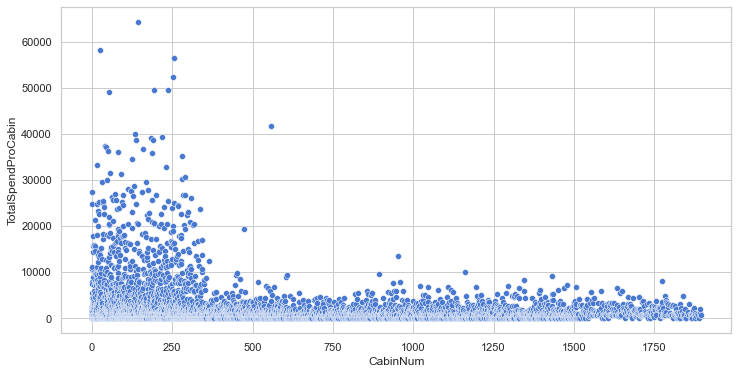

In [49]:
d= for_visual_df.groupby(['CabinNum', 'CabinDeck'], as_index=False).agg(TotalSpendProCabin = ('TotalSpend', 'sum'))

fig, axs = plt.subplots(figsize=(12, 6))

sns.scatterplot(data=d, x='CabinNum', y='TotalSpendProCabin', ax=axs)

<AxesSubplot:xlabel='CabinDeck', ylabel='VIP'>

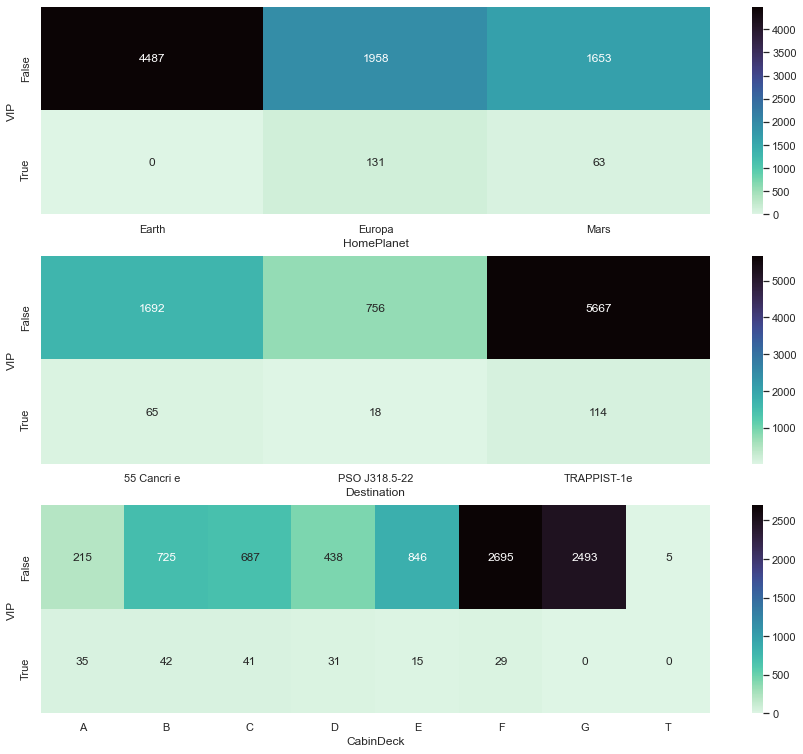

In [50]:
fig, axs = plt.subplots(3, 1, figsize=(15, 13))

d=for_visual_df.groupby(['VIP', 'HomePlanet']).size().unstack().fillna(0)
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r', ax=axs[0])

d=for_visual_df.groupby(['VIP', 'Destination']).size().unstack().fillna(0)
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r', ax=axs[1])

d=for_visual_df.groupby(['VIP', 'CabinDeck']).size().unstack().fillna(0)
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r', ax=axs[2])

    -- Es gibt keine VIP-Passagiere auf Deck G, alle Passagiere auf Deck G sind vom Planeten Erde

In [51]:
for_visual_df.loc[(for_visual_df['VIP'].notnull()) & (for_visual_df['VIP']) & (for_visual_df['HomePlanet'].isnull()), :]

PassengerId HomePlanet CryoSleep     Cabin  Destination   Age   VIP  \
291      0321_01        NaN     False    F/61/S  TRAPPIST-1e  59.0  True   
365      0402_01        NaN      True    D/15/S  55 Cancri e  32.0  True   
405      0444_02        NaN     False    F/99/P  TRAPPIST-1e  26.0  True   
7042     7500_01        NaN     False  F/1432/S  TRAPPIST-1e  54.0  True   
7786     8314_02        NaN     False   D/245/S  55 Cancri e  29.0  True   

      RoomService  FoodCourt  ShoppingMall  ...  IsSingle  NoSpend IsChild  \
291        1018.0        0.0         209.0  ...      True    False   False   
365           0.0        0.0           0.0  ...      True     True   False   
405        1869.0        0.0         136.0  ...     False    False   False   
7042       1770.0        7.0         228.0  ...      True    False   False   
7786          0.0     2949.0           0.0  ...     False    False   False   

      namesakes_num_in_group NameLength  RoomService_log FoodCourt_log  \
291                      0.0       12.0         3.008174      0.000000   
365                      0.0       12.0         0.000000      0.000000   
405                      1.0       11.0         3.271842      0.000000   
7042                     0.0       11.0         3.248219      0.903090   
7786                     1.0       17.0         0.000000      3.469822   

      ShoppingMall_log   Spa_log  VRDeck_log  
291           2.322219  0.000000    0.000000  
365           0.000000  0.000000    0.000000  
405           2.136721  0.000000    0.000000  
7042          2.359835  0.000000    0.000000  
7786          0.000000  0.477121    2.816241  

[5 rows x 34 columns]

<AxesSubplot:xlabel='VIP', ylabel='CryoSleep'>

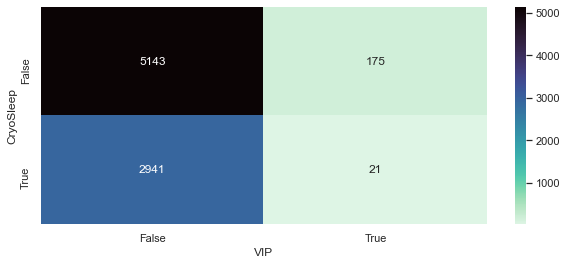

In [52]:
fig, axs = plt.subplots(figsize=(10, 4))

d=for_visual_df.groupby(['CryoSleep', 'VIP']).size().unstack().fillna(0)
sns.heatmap(d, annot=True, fmt='g', cmap='mako_r', ax=axs)

In [53]:
# d = for_visual_df.groupby('GroupId', as_index=False).agg(
#     sum_cryosleep=('CryoSleep', 'sum'),
#     count = ('PassengerId','size'))
# d.sort_values('sum_cryosleep', ascending=False).head(5)

In [54]:
for_visual_df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'CabinDeck', 'CabinNum', 'CabinSide', 'GroupId',
       'NumInGroup', 'GroupSize', 'TotalSpend', 'Route', 'FirstName',
       'LastName', 'IsSingle', 'NoSpend', 'IsChild', 'namesakes_num_in_group',
       'NameLength', 'RoomService_log', 'FoodCourt_log', 'ShoppingMall_log',
       'Spa_log', 'VRDeck_log'],
      dtype='object')

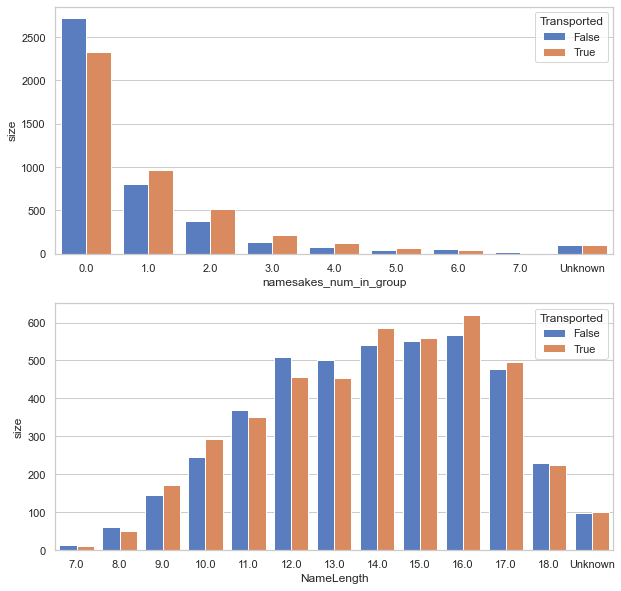

In [55]:
name_features = ['namesakes_num_in_group', 'NameLength', ]

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
i = 0
axe = axs.ravel()

for i, f in enumerate(name_features):
    d2 = for_visual_df.groupby([f, 'Transported'], as_index=False, dropna=False).size()
    d2= d2.fillna('Unknown')
    sns.barplot(x=f, y="size",
                hue="Transported",
                data=d2, ax=axe[i])

In [56]:
# fig, axs = plt.subplots(6, 1, figsize=(20, 45))
# i = 0
# axe = axs.ravel()

# for i, f in enumerate(category_features):
   
#     d2 = for_visual_df.groupby([f, 'IsSingle'], as_index=False, dropna=False).size()
#     d2= d2.fillna('Unknown')
#     sns.barplot(x=f, y="size",
#                 hue="IsSingle",
#                 data=d2, ax=axe[i])

## Data Vorbereitung

In [57]:
expenses_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", 'VRDeck']

In [58]:
data['Transported'] = data["Transported"].astype(int)

In [59]:
# trenne in trainings und test daten
data_train, data_test = train_test_split(data, train_size=0.8, random_state=7)
# data_train = data

# trenne in X_train/y_train und X_test/y_test 
X_train = data_train.drop(columns="Transported")
y_train = data_train.loc[:, "Transported"]


X_test = data_test.drop(columns="Transported")
y_test = data_test.loc[:, "Transported"]

In [60]:
# Data Transformationen:
# - Name - split: 'FirstName', 'LastName'
#- PassengerId - split: 'GroupId', 'NumInGroup' -- to float

In [61]:
def new_features_create(df):
    df[['FirstName', 'LastName']] = df['Name'].str.split(' ', expand=True)
    df[['GroupId', 'NumInGroup']] = df['PassengerId'].str.split('_', expand=True)
    df[['CabinDeck', 'CabinNum', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)
    df['IsChild'] = df.loc[:, 'Age'] <= 18
    df['TotalSpend'] = df.loc[:, expenses_cols].sum(axis=1)
    
    df['GroupId'] = df.loc[:,'GroupId'].astype(float) 
    df['NumInGroup'] = df.loc[:,'NumInGroup'].astype(float)
    df['CabinNum'] = df.loc[:,'CabinNum'].astype(float)
    
    GroupSize_df = df.groupby('GroupId', as_index=False).agg(GroupSize = ('PassengerId', 'count'))
    df = df.merge(GroupSize_df, how='left', left_on='GroupId', right_on='GroupId', copy=False)

    df['IsSingle'] = df.loc[:, 'GroupSize'].apply(lambda x: x==1 )
    
    return df

    
X_train = new_features_create(X_train)

In [62]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6954 entries, 0 to 6953
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6954 non-null   object 
 1   HomePlanet    6788 non-null   object 
 2   CryoSleep     6789 non-null   object 
 3   Cabin         6797 non-null   object 
 4   Destination   6801 non-null   object 
 5   Age           6800 non-null   float64
 6   VIP           6788 non-null   object 
 7   RoomService   6808 non-null   float64
 8   FoodCourt     6806 non-null   float64
 9   ShoppingMall  6796 non-null   float64
 10  Spa           6802 non-null   float64
 11  VRDeck        6803 non-null   float64
 12  Name          6789 non-null   object 
 13  FirstName     6789 non-null   object 
 14  LastName      6789 non-null   object 
 15  GroupId       6954 non-null   float64
 16  NumInGroup    6954 non-null   float64
 17  CabinDeck     6797 non-null   object 
 18  CabinNum      6797 non-null 

In [63]:
X_train.head()

PassengerId HomePlanet CryoSleep     Cabin  Destination   Age    VIP  \
0     6309_02      Earth       NaN  G/1023/S  TRAPPIST-1e   7.0  False   
1     2908_02        NaN     False   F/553/S  TRAPPIST-1e  13.0  False   
2     0548_01      Earth     False    E/36/S  TRAPPIST-1e  24.0  False   
3     8757_01      Earth     False  G/1409/S  TRAPPIST-1e  28.0  False   
4     1644_01      Earth     False   F/327/P  55 Cancri e  14.0  False   

   RoomService  FoodCourt  ShoppingMall  ...    LastName  GroupId NumInGroup  \
0          0.0        0.0           0.0  ...   Rodricker   6309.0        2.0   
1        649.0        2.0           0.0  ...  Berreranks   2908.0        2.0   
2          0.0       86.0         704.0  ...     Webstes    548.0        1.0   
3          1.0     1484.0         210.0  ...    Danielps   8757.0        1.0   
4          0.0        2.0           0.0  ...  Waltonnedy   1644.0        1.0   

  CabinDeck CabinNum  CabinSide  IsChild TotalSpend  GroupSize IsSingle  
0         G   1023.0          S     True        0.0          4    False  
1         F    553.0          S     True      918.0          1     True  
2         E     36.0          S    False      791.0          1     True  
3         G   1409.0          S    False     1700.0          1     True  
4         F    327.0          P     True      796.0          1     True  

[5 rows x 24 columns]

HomePlanet      201 - durch einen häufig vorkommenden Wert ersetzen
CryoSleep       217 - durch einen häufig vorkommenden Wert ersetzen
Cabin           199 
Destination     182 - durch einen häufig vorkommenden Wert ersetzen
Age             179
VIP             203 - durch einen häufig vorkommenden Wert ersetzen
RoomService     181 
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

### HomePlanet

In [64]:
def HomePlanet_update(df, source_df):
    print('------ HomePlanet_update ------------')
    # в каждой каюте только одна планета
    planet_for_group_df = source_df.loc[source_df['HomePlanet'].notnull(), :].groupby(['GroupId'], as_index=False).agg(
                num_planets=('HomePlanet', lambda x: len(x.unique())),
                not_null_planet = ('HomePlanet', lambda x: x.unique()[0]))
    
    start_nulls_num = df.loc[df['HomePlanet'].isnull(), :].shape[0]
 
    print('HomePlanet NULLs:', start_nulls_num)
    
    
    df['HomePlanet'] = df.apply(
    lambda x: (planet_for_group_df.loc[planet_for_group_df['GroupId'] == x.GroupId, 'not_null_planet'].iloc[0] if planet_for_group_df.loc[planet_for_group_df['GroupId'] == x.GroupId, 'not_null_planet'].shape[0] > 0 else np.nan)
    if x.HomePlanet is np.nan else x.HomePlanet , axis=1)


    print('1. (after replacement through the Сabin) HomePlanet NULLs:', df.loc[df['HomePlanet'].isnull(), :].shape[0])
    
    #----------------------------------------------------------------------
    # если палуба A, B, C; T, то Europa. Если G, то Earth
    df.loc[(df['HomePlanet'].isnull()) & (df['CabinDeck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'
    df.loc[(df['HomePlanet'].isnull()) & (df['CabinDeck'].isin(['G'])), 'HomePlanet']='Earth'
    
    print('2. (after replacement through the Deck) HomePlanet NULLs:', df.loc[df['HomePlanet'].isnull(), :].shape[0])
    
    # ---------------------------------------------------------------------
    # все люди с одной фамилией летят с одной планеты
    planet_for_lastname_df = source_df.loc[
            source_df['HomePlanet'].notnull(), :].groupby(['LastName'], as_index=False).agg(
                                num_planets=('HomePlanet', lambda x: len(x.unique())),
                                not_null_planet = ('HomePlanet', lambda x: x.unique()[0]))
    
    df['HomePlanet'] = df.apply(
    lambda x: (planet_for_lastname_df.loc[planet_for_lastname_df['LastName'] == x.LastName, 'not_null_planet'].iloc[0] if planet_for_lastname_df.loc[planet_for_lastname_df['LastName'] == x.LastName, 'not_null_planet'].shape[0] > 0 else np.nan)
    if x.HomePlanet is np.nan else x.HomePlanet , axis=1)
    
    print('3. (after replacement through the LastName) HomePlanet NULLs:', df.loc[df['HomePlanet'].isnull(), :].shape[0])

    #----------------------------------------------------------------------
    df.loc[(df['HomePlanet'].isnull()) & (df['Destination'].isin(['TRAPPIST-1e', 'PSO J318.5-22'])) & (df['CabinDeck'] == 'D'), 'HomePlanet']='Mars'   
    df.loc[(df['HomePlanet'].isnull()) & ~(df['CabinDeck'] == 'D'), 'HomePlanet']='Earth'
    df.loc[(df['HomePlanet'].isnull()) & (df['Destination'] == '55 Cancri e') & (df['CabinDeck'] == 'D'), 'HomePlanet']='Europa'
    
    print('4. (after replacement through the Destination):', df.loc[df['HomePlanet'].isnull(), :].shape[0])
    #------------------------------------------------------------------------
    
    df.fillna(value= {'HomePlanet': 'Earth'}, inplace=True)
    
    print('5. (after replacement by the most common value) HomePlanet NULLs:', df.loc[df['HomePlanet'].isnull(), :].shape[0])

    return df
X_train = HomePlanet_update(X_train, for_visual_df)

------ HomePlanet_update ------------
HomePlanet NULLs: 166
1. (after replacement through the Сabin) HomePlanet NULLs: 94
2. (after replacement through the Deck) HomePlanet NULLs: 54
3. (after replacement through the LastName) HomePlanet NULLs: 7
4. (after replacement through the Destination): 0
5. (after replacement by the most common value) HomePlanet NULLs: 0


### Destination

In [65]:
for_visual_df.loc[
            for_visual_df['Destination'].notnull(), :].groupby(['LastName'], as_index=False).agg(
                                num_planets=('Destination', lambda x: len(x.unique())),
                                not_null_planet = ('Destination', lambda x: x.unique()[0])).sort_values('num_planets', ascending=False)

LastName  num_planets not_null_planet
1858      Slable            3   PSO J318.5-22
2099   Villenson            3   PSO J318.5-22
610    Dotsondez            3     55 Cancri e
2102   Vinozarks            3     TRAPPIST-1e
2103     Vinston            3   PSO J318.5-22
...          ...          ...             ...
1018     Howence            1   PSO J318.5-22
1017    Howayery            1     TRAPPIST-1e
1015       Hotty            1     TRAPPIST-1e
1012      Horthy            1     TRAPPIST-1e
2208  Youngrayes            1     TRAPPIST-1e

[2209 rows x 3 columns]

In [66]:
for_visual_df.loc[for_visual_df['Destination'].notnull(), :].groupby(['GroupId'], as_index=False).agg(
    num_planets=('Destination', lambda x: len(x.unique())),
    not_null_planet = ('Destination', lambda x: x.unique()[0])).sort_values('num_planets', ascending=False)

GroupId  num_planets not_null_planet
4426   6672.0            3     TRAPPIST-1e
885    1350.0            3     55 Cancri e
5899   8956.0            3     TRAPPIST-1e
1916   2892.0            3   PSO J318.5-22
5860   8886.0            3     55 Cancri e
...       ...          ...             ...
2477   3757.0            1     TRAPPIST-1e
2476   3756.0            1     TRAPPIST-1e
420     631.0            1     TRAPPIST-1e
2474   3754.0            1     TRAPPIST-1e
0         1.0            1     TRAPPIST-1e

[6114 rows x 3 columns]

In [67]:
def Destination_update(df):
    print('------ Destination_update ------------')
    start_nulls_num = df.loc[df['Destination'].isnull(), :].shape[0]
 
    print('Destination NULLs:', start_nulls_num)
    
    df.fillna(value= {'Destination': 'TRAPPIST-1e'}, inplace=True)
    
    print('(after replacement by the most common value) Destination NULLs:', df.loc[df['Destination'].isnull(), :].shape[0])
    
    return df
    
X_train= Destination_update(X_train)
    

------ Destination_update ------------
Destination NULLs: 153
(after replacement by the most common value) Destination NULLs: 0


### LastName

In [68]:
num_unique_last_names_in_group = for_visual_df[for_visual_df['GroupSize'] > 1].groupby(['GroupId'], as_index=False).agg(
                lastname_num_in_group = ('LastName', lambda x: len(x.value_counts()))).groupby('lastname_num_in_group').size().sort_values()
num_unique_last_names_in_group

lastname_num_in_group
4       1
3      23
2     225
1    1163
dtype: int64

Text(0.5, 1.0, 'Number of unique surnames by group')

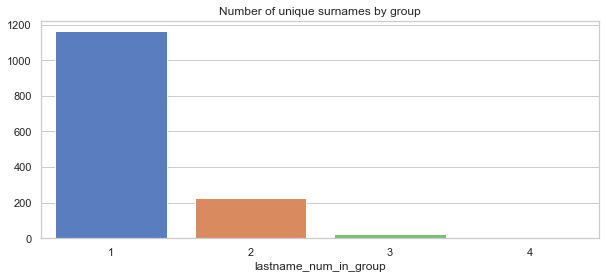

In [69]:
# Countplot of unique values
plt.figure(figsize=(10,4))
sns.barplot(x=num_unique_last_names_in_group.index, y=num_unique_last_names_in_group.values)
plt.title('Number of unique surnames by group')

In [70]:
for_visual_df.loc[for_visual_df['LastName'].notnull(), ['GroupId', 'LastName']].groupby(['GroupId'], as_index=False).agg(
                        not_null_last_name = ('LastName', lambda x: x.value_counts().index[0]))   

GroupId not_null_last_name
0         1.0          Ofracculy
1         2.0              Vines
2         3.0             Susent
3         4.0        Santantines
4         5.0         Hinetthews
...       ...                ...
6108   9275.0            Conable
6109   9276.0          Noxnuther
6110   9278.0          Mondalley
6111   9279.0             Connon
6112   9280.0          Hontichre

[6113 rows x 2 columns]

In [71]:
# suchen nach LastName in der gleichen Gruppe und aktualisiren null Werte

def LastName_update(df):
    print('------ LastName_update ------------')
    print('LastName NULLs:', df.loc[df['LastName'].isnull()].shape[0])
          
    lastnames_for_nulls_df = df.loc[df['LastName'].notnull(), ['GroupId', 'LastName']].groupby(['GroupId'], as_index=False).agg(
                        not_null_last_name = ('LastName', lambda x: x.value_counts().index[0]))  
    print(lastnames_for_nulls_df.shape)
          
    df['LastName'] = df.apply(
            lambda x: (
                lastnames_for_nulls_df.loc[lastnames_for_nulls_df['GroupId'] == x.GroupId, 'not_null_last_name'].iloc[0]
                    if lastnames_for_nulls_df.loc[lastnames_for_nulls_df['GroupId'] == x.GroupId, 'not_null_last_name'].shape[0] > 0 else np.nan)
                if x.LastName is np.nan else x.LastName , axis=1)      
          
    print('(after update) LastName NULLs:', df.loc[df['LastName'].isnull()].shape[0])
    
    #--------------------------------------------------------
        # 1. число однофамильцев в группе
    namesakes_in_group_df = df.groupby(['LastName', 'GroupId'], as_index=False).agg(
                namesakes_num_in_group = ('PassengerId', 'count'))

    df = df.merge(
        namesakes_in_group_df, how='left',
        left_on=['LastName', 'GroupId'],
        right_on=['LastName', 'GroupId'])

    df['namesakes_num_in_group'] = df['namesakes_num_in_group'] - 1
    
    print('namesakes_num_in_group NULLs:', df.loc[df['namesakes_num_in_group'].isnull()].shape[0])
    
    df.fillna(value= {'namesakes_num_in_group': 0}, inplace=True)
    
    print('namesakes_num_in_group NULLs:', df.loc[df['namesakes_num_in_group'].isnull()].shape[0])
    
    #----------------------------------------------------------------
    
    df.loc[df['Name'].isnull(), 'Name'] =  df.loc[df['Name'].isnull(), 'LastName']
    df['NameLength'] = df.loc[:, 'Name'].str.len()
    df.fillna(value= {'NameLength': 0}, inplace=True)
    
    return df

    
#     row_null_last_name = df.loc[df['LastName'].isnull(), ['PassengerId', 'GroupId']]
    
#     tmp = row_null_last_name.merge(
#         df.loc[df['LastName'].notnull(), ['GroupId', 'LastName']],
#         how='left',
#         left_on='GroupId',
#         right_on='GroupId'
#     )
    
#     lastnames_for_nulls_df = tmp.loc[tmp['LastName'].notnull()].groupby(
#     'PassengerId',
#     as_index=False).agg(
#         not_null_lastname = ('LastName', lambda x: x.value_counts().index[0])
#     )
    
#     df.loc[df['PassengerId'].isin(lastnames_for_nulls_df['PassengerId']), 'LastName'] = lastnames_for_nulls_df.loc[:, 'not_null_lastname'].values
    
#     return lastnames_for_nulls_df.shape[0]

In [72]:
X_train = LastName_update(X_train)

------ LastName_update ------------
LastName NULLs: 165
(5127, 2)
(after update) LastName NULLs: 95
namesakes_num_in_group NULLs: 95
namesakes_num_in_group NULLs: 0


### CabinDeck

In [73]:
tmp = X_train.loc[X_train['CabinDeck'].notnull(), ['GroupId', 'CabinDeck']].groupby(['GroupId'], as_index=False).agg(
                        not_null_cabin_deck = ('CabinDeck', lambda x: len(x.value_counts()))).sort_values('not_null_cabin_deck')  


tmp.groupby('not_null_cabin_deck').size()

not_null_cabin_deck
1    4826
2     300
3      13
dtype: int64

In [74]:
def CabinDeck_update(df):
    print('------ CabinDeck_update ------------')
    print('CabinDeck NULLs:', df.loc[df['CabinDeck'].isnull()].shape[0])
    
    cabindecks_for_nulls_df = df.loc[df['CabinDeck'].notnull(), ['GroupId', 'CabinDeck']].groupby(['GroupId'], as_index=False).agg(
                        not_null_cabin_deck = ('CabinDeck', lambda x: x.value_counts().index[0])).sort_values('not_null_cabin_deck')
    
    
    df['CabinDeck'] = df.apply(
            lambda x: (
                cabindecks_for_nulls_df.loc[cabindecks_for_nulls_df['GroupId'] == x.GroupId, 'not_null_cabin_deck'].iloc[0]
                    if cabindecks_for_nulls_df.loc[cabindecks_for_nulls_df['GroupId'] == x.GroupId, 'not_null_cabin_deck'].shape[0] > 0 else np.nan)
                if x.CabinDeck is np.nan else x.CabinDeck , axis=1)      
          
    
    print('(after update throw GroupId) CabinDeck NULLs:', df.loc[df['CabinDeck'].isnull()].shape[0])
    
    #---------------------------------------------------------------------------------
    
#     Mars -> F
#     Europa -> B
#     Earth -> G

    df.loc[(df['CabinDeck'].isnull()) & (df['HomePlanet'] == 'Mars'), 'CabinDeck'] = 'F'
    df.loc[(df['CabinDeck'].isnull()) & (df['HomePlanet'] == 'Earth'), 'CabinDeck'] = 'G'
    df.loc[(df['CabinDeck'].isnull()) & (df['HomePlanet'] == 'Europa'), 'CabinDeck'] = 'B'
    print('(after update throw HomePlanet) CabinDeck NULLs:', df.loc[df['CabinDeck'].isnull()].shape[0])
    
    return df

X_train = CabinDeck_update(X_train)    

------ CabinDeck_update ------------
CabinDeck NULLs: 157
(after update throw GroupId) CabinDeck NULLs: 83
(after update throw HomePlanet) CabinDeck NULLs: 0


### CabinNum

In [75]:
decks = sorted(list(for_visual_df.CabinDeck.value_counts().index))

decks


['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']

In [76]:
def CabinNum_update(df, source_data):
    print('------ CabinNum_update ------------')
    null_ind = df.loc[df['CabinNum'].isnull()].index
    
    
    print('CabinNum NULLs:', df.loc[df['CabinNum'].isnull()].shape[0])
    decks = sorted(list(source_data.CabinDeck.value_counts().index))
    print(decks)
    
    df_y_pred= []
    
    for deck in decks:
        df_x_pred = df.loc[(df['CabinNum'].isnull()) & (df['CabinDeck'] == deck), ['GroupId']]
        
        if df_x_pred.shape[0] > 0:
            
            df_x_train = df.loc[(df['CabinNum'].notnull()) & (df['CabinDeck'] == deck), ['GroupId']]
            df_y_train = df.loc[(df['CabinNum'].notnull()) & (df['CabinDeck'] == deck), ['CabinNum']]
        

            lr_mod = LinearRegression()
            lr_mod.fit(df_x_train, df_y_train)
            df_y_pred = lr_mod.predict(df_x_pred)
        
            print(deck, df_y_pred.shape)
        
        
            df.loc[(df['CabinNum'].isnull()) & (df['CabinDeck'] == deck), ['CabinNum']] = df_y_pred
    print('CabinNum NULLs:', df.loc[df['CabinNum'].isnull()].shape[0])
    
    return (null_ind, df)
        
null_cabin_num_ind, X_train = CabinNum_update(X_train, for_visual_df)

------ CabinNum_update ------------
CabinNum NULLs: 157
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
A (6, 1)
B (29, 1)
C (14, 1)
D (5, 1)
E (9, 1)
F (29, 1)
G (65, 1)
CabinNum NULLs: 0


<AxesSubplot:xlabel='CabinNum', ylabel='GroupId'>

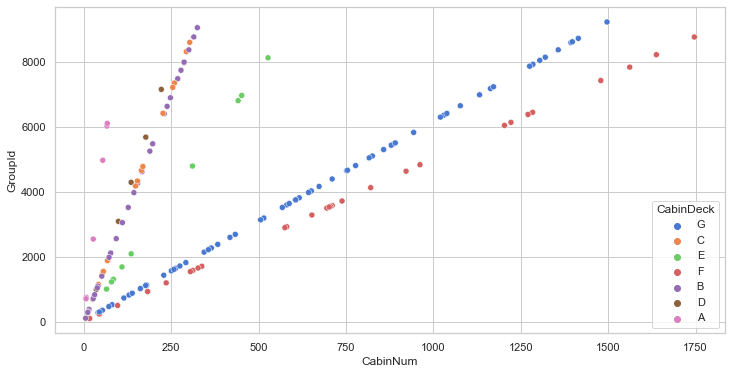

In [77]:
fig, axs = plt.subplots(figsize=(12, 6))

sns.scatterplot(data=X_train.loc[null_cabin_num_ind, :], x='CabinNum', y='GroupId', hue='CabinDeck', ax=axs)

### CabinSide

In [78]:
tmp = X_train.loc[X_train['CabinSide'].notnull(), ['GroupId', 'CabinSide']].groupby(['GroupId'], as_index=False).agg(
                        not_null_cabin_side = ('CabinSide', lambda x: len(x.value_counts()))).sort_values('not_null_cabin_side')  


tmp.groupby('not_null_cabin_side').size()

not_null_cabin_side
1    5139
dtype: int64

In [79]:
def CabinSide_update(df, source_data):
    print('------ CabinSide_update ------------')
    print('CabinSide NULLs:', df.loc[df['CabinSide'].isnull()].shape[0])
    
    cabin_side_for_group_id_df = source_data.loc[
            source_data['CabinSide'].notnull(), :].groupby(['GroupId'], as_index=False).agg(
                                not_null_cabin_side = ('CabinSide', lambda x: x.unique()[0]))
    
    df['CabinSide'] = df.apply(
    lambda x: 
        (cabin_side_for_group_id_df.loc[cabin_side_for_group_id_df['GroupId'] == x.GroupId, 'not_null_cabin_side'].iloc[0] if cabin_side_for_group_id_df.loc[cabin_side_for_group_id_df['GroupId'] == x.GroupId, 'not_null_cabin_side'].shape[0] > 0 else np.nan)
        if x.CabinSide is np.nan else x.CabinSide , axis=1)
    
    print('CabinSide NULLs:', df.loc[df['CabinSide'].isnull()].shape[0])
    
    #-----------------------------------------------------
    
    df.fillna(value= {'CabinSide': 'O'}, inplace=True)
    print('CabinSide NULLs:', df.loc[df['CabinSide'].isnull()].shape[0])
    
    return df
    
X_train = CabinSide_update(X_train, for_visual_df)

------ CabinSide_update ------------
CabinSide NULLs: 157
CabinSide NULLs: 81
CabinSide NULLs: 0


In [80]:
X_train.CabinSide.unique()

array(['S', 'P', 'O'], dtype=object)

### VIP             

In [81]:
def VIP_update(df):
    print('------ VIP_update ------------')
    print('VIP NULLs:', df.loc[df['VIP'].isnull()].shape[0])
    
    df.fillna(value= {'VIP': False}, inplace=True)
    
    print('VIP NULLs:', df.loc[df['VIP'].isnull()].shape[0])
    
    return df
    
    
X_train = VIP_update(X_train)

------ VIP_update ------------
VIP NULLs: 166
VIP NULLs: 0


### CryoSleep

In [82]:
for_visual_df.loc[(for_visual_df['CryoSleep'].notnull()) & (for_visual_df['CryoSleep']), 'TotalSpend'].sum()

0.0

In [83]:
def CryoSleep_update(df):
    print('------ CryoSleep_update ------------')
    print(df.loc[df['CryoSleep'].isnull(), :].shape[0])
    
    df.loc[(df['CryoSleep'].isnull()) & (df['TotalSpend'] == 0), 'CryoSleep'] = True
    
    print(df.loc[df['CryoSleep'].isnull(), :].shape[0])
    
    #------------------------------------------------------------
    
    df.fillna(value= {'CryoSleep': False}, inplace=True)
    print(df.loc[df['CryoSleep'].isnull(), :].shape[0])
    
    return df
    
X_train = CryoSleep_update(X_train)    

------ CryoSleep_update ------------
165
92
0


### Age

In [84]:
def get_age_medians(df):

    return df.loc[:, ['IsSingle', 'HomePlanet', 'VIP', 'Age']].groupby(
        ['IsSingle', 'HomePlanet', 'VIP'], 
        as_index=False).agg('median')

In [85]:
def Age_update(df, median_values):
    print('------ Age_update ------------')
    print('Nulls in Expenses:', df.loc[:, 'Age'].isna().sum())
    
    for index, row in median_values.iterrows():
        
        cond = (df['IsSingle'] == row['IsSingle']) & (df['VIP'] == row['VIP']) & (df['HomePlanet'] == row['HomePlanet'])
        
        df.loc[cond, :] = df.loc[cond, :].fillna(value = {'Age': row['Age']})

    print('Nulls in Expenses:', df.loc[:, 'Age'].isna().sum())   
    
    #-----------------------------------------------------------------------------
    
    df.fillna(value= {'Age': 0}, inplace=True)
    print('Nulls in Expenses:', df.loc[:, 'Age'].isna().sum())
    
    return df

age_medians_train = get_age_medians(X_train)

X_train = Age_update(X_train, age_medians_train)

------ Age_update ------------
Nulls in Expenses: 154
Nulls in Expenses: 0
Nulls in Expenses: 0


### Expenses ("RoomService", "FoodCourt", "ShoppingMall", "Spa", 'VRDeck')

In [86]:
group_cols = ['IsSingle', 'VIP', 'HomePlanet']
cols= expenses_cols + group_cols

not_child_not_sleep_df = X_train.loc[(X_train['Age'] >= 13) & (X_train['CryoSleep'] == False), :]
print(not_child_not_sleep_df.shape)


no_spend_df = not_child_not_sleep_df.loc[
    (not_child_not_sleep_df['ShoppingMall']==0) &
    (not_child_not_sleep_df['FoodCourt']==0) &
    (not_child_not_sleep_df['RoomService']==0) &
    (not_child_not_sleep_df['Spa']==0) &
    (not_child_not_sleep_df['VRDeck']==0), :
]

print(no_spend_df.shape)
    
expenses_means = not_child_not_sleep_df.loc[:, cols].groupby(group_cols, as_index=False).agg('mean')
expenses_means

(4117, 26)
(80, 26)


IsSingle    VIP HomePlanet  RoomService    FoodCourt  ShoppingMall  \
0     False  False      Earth   232.229602   219.576923    206.981025   
1     False  False     Europa   302.703704  2587.694323    289.389868   
2     False  False       Mars  1016.549153   106.812081    510.896907   
3     False   True     Europa   438.547170  2905.092593    188.452830   
4     False   True       Mars   874.750000   146.750000    657.210526   
5      True  False      Earth   217.983925   217.753999    211.233844   
6      True  False     Europa   204.185915  2633.585915    290.019718   
7      True  False       Mars   994.663677   102.232143    585.106430   
8      True   True     Europa   359.055556  2992.617647    223.971429   
9      True   True       Mars   860.062500   108.516129    358.878788   

           Spa       VRDeck  
0   245.934489   215.865275  
1  1612.439560  1593.158242  
2   196.180272    90.174497  
3  1220.000000  2686.283019  
4   176.476190    44.000000  
5   221.101161   214.819536  
6  1478.245070  1551.662011  
7   167.908686    91.647982  
8  1439.722222  1835.472222  
9   231.303030    51.848485

In [87]:
expenses_medians = not_child_not_sleep_df.loc[:, cols].groupby(group_cols, as_index=False).agg('median')
expenses_medians

IsSingle    VIP HomePlanet  RoomService  FoodCourt  ShoppingMall    Spa  \
0     False  False      Earth          5.0        4.0           4.0    2.0   
1     False  False     Europa          0.0     1421.0           0.0  445.0   
2     False  False       Mars        853.0        0.0         170.0    0.0   
3     False   True     Europa          0.0     1525.0           0.0  417.0   
4     False   True       Mars        788.0        0.0         354.0    4.0   
5      True  False      Earth          3.0        4.0           4.0    6.0   
6      True  False     Europa          0.0     1390.0           0.0  279.0   
7      True  False       Mars        730.5        0.0         269.0    0.0   
8      True   True     Europa          0.0     2343.0           0.0  269.0   
9      True   True       Mars        687.5        0.0         177.0    0.0   

   VRDeck  
0     7.0  
1   473.0  
2     0.0  
3  1547.0  
4     0.0  
5     4.0  
6   444.0  
7     0.0  
8   680.0  
9     0.0

In [88]:
for index, row in expenses_medians.iterrows():
    print(row[expenses_cols].to_dict())
    print('---------------------------')

{'RoomService': 5.0, 'FoodCourt': 4.0, 'ShoppingMall': 4.0, 'Spa': 2.0, 'VRDeck': 7.0}
---------------------------
{'RoomService': 0.0, 'FoodCourt': 1421.0, 'ShoppingMall': 0.0, 'Spa': 445.0, 'VRDeck': 473.0}
---------------------------
{'RoomService': 853.0, 'FoodCourt': 0.0, 'ShoppingMall': 170.0, 'Spa': 0.0, 'VRDeck': 0.0}
---------------------------
{'RoomService': 0.0, 'FoodCourt': 1525.0, 'ShoppingMall': 0.0, 'Spa': 417.0, 'VRDeck': 1547.0}
---------------------------
{'RoomService': 788.0, 'FoodCourt': 0.0, 'ShoppingMall': 354.0, 'Spa': 4.0, 'VRDeck': 0.0}
---------------------------
{'RoomService': 3.0, 'FoodCourt': 4.0, 'ShoppingMall': 4.0, 'Spa': 6.0, 'VRDeck': 4.0}
---------------------------
{'RoomService': 0.0, 'FoodCourt': 1390.0, 'ShoppingMall': 0.0, 'Spa': 279.0, 'VRDeck': 444.0}
---------------------------
{'RoomService': 730.5, 'FoodCourt': 0.0, 'ShoppingMall': 269.0, 'Spa': 0.0, 'VRDeck': 0.0}
---------------------------
{'RoomService': 0.0, 'FoodCourt': 2343.0, 'Sho

In [89]:
def get_expenses_means(df):
    not_child_not_sleep_df = df.loc[(X_train['Age'] >= 13) & (df['CryoSleep'] == False), :]
    
    expenses_means = not_child_not_sleep_df.loc[:, cols].groupby(group_cols, as_index=False).agg('mean')
    return expenses_means

In [90]:
def Expenses_update(df, median_values):
    print('------ Expenses_update ------------')
    values = {"RoomService": 0, "FoodCourt": 0, "ShoppingMall": 0, "Spa": 0, 'VRDeck': 0}
    

    print('Nulls in Expenses:', df.loc[:, expenses_cols].isna().sum().sum(axis = 0))
    
    df.loc[(df['Age'] < 13), :] = df.loc[(df['Age'] < 13), :].fillna(value = values)
    
    print('Nulls in Expenses:', df.loc[:, expenses_cols].isna().sum().sum(axis = 0))
    #-------------------------------------------------------------------------------
    
    df.loc[(df['CryoSleep'].notnull())
           & (df['CryoSleep']), :] = df.loc[(df['CryoSleep'].notnull()) & (df['CryoSleep']), :].fillna(value = values)
    
    print('Nulls in Expenses:', df.loc[:, expenses_cols].isna().sum().sum(axis = 0))
    
    #-------------------------------------------------------------------------
    
    for index, row in median_values.iterrows():
        
        cond = (df['IsSingle'] == row['IsSingle']) & (df['VIP'] == row['VIP']) & (df['HomePlanet'] == row['HomePlanet'])
        
        tmp = df.loc[cond, expenses_cols]
        print(tmp.shape)
        
        df.loc[cond, :] = df.loc[cond, :].fillna(value = row[expenses_cols].to_dict())

    print('Nulls in Expenses:', df.loc[:, expenses_cols].isna().sum().sum(axis = 0))   
    
    #-----------------------------------------------------------------------------
    
    df.fillna(value= values, inplace=True)
    print('Nulls in Expenses:', df.loc[:, expenses_cols].isna().sum().sum(axis = 0))
    
    return df

expenses_means_train = get_expenses_means(X_train)

X_train = Expenses_update(X_train, expenses_means_train)

------ Expenses_update ------------
Nulls in Expenses: 755
Nulls in Expenses: 681
Nulls in Expenses: 421
(1177, 5)
(923, 5)
(615, 5)
(64, 5)
(21, 5)
(2624, 5)
(683, 5)
(770, 5)
(44, 5)
(33, 5)
Nulls in Expenses: 0
Nulls in Expenses: 0


In [91]:
def log_expenses(df):
    print('------ log_expenses ------------')
    num_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' ]

    for f in num_features:
        df[f] = np.log10(df[f] + 1)
        
    return df
        
X_train = log_expenses(X_train)

------ log_expenses ------------


In [92]:
def New_features_update(df):
    print('------ New_features_update ------------')
    df['TotalSpend'] = df.loc[:, expenses_cols].sum(axis=1)
    df['NoSpend'] = df.loc[:, 'TotalSpend'].apply(lambda x: np.nan if math.isnan(x) else x==0)
    df['IsChild'] = df.loc[:, 'Age'] <= 18
    df['Route'] = df['HomePlanet'] + ' - ' + df['Destination']
    
    return df
    
X_train = New_features_update(X_train)

------ New_features_update ------------


In [93]:
X_train.isnull().sum()

PassengerId                 0
HomePlanet                  0
CryoSleep                   0
Cabin                     157
Destination                 0
Age                         0
VIP                         0
RoomService                 0
FoodCourt                   0
ShoppingMall                0
Spa                         0
VRDeck                      0
Name                       95
FirstName                 165
LastName                   95
GroupId                     0
NumInGroup                  0
CabinDeck                   0
CabinNum                    0
CabinSide                   0
IsChild                     0
TotalSpend                  0
GroupSize                   0
IsSingle                    0
namesakes_num_in_group      0
NameLength                  0
NoSpend                     0
Route                       0
dtype: int64

In [94]:
X_train.drop(['Cabin', 'PassengerId', 'Name', 'FirstName', 'LastName'], axis=1, inplace=True)

In [95]:
X_train.describe()

Age  RoomService    FoodCourt  ShoppingMall          Spa  \
count  6954.000000  6954.000000  6954.000000   6954.000000  6954.000000   
mean     28.704630     0.792119     0.853230      0.725656     0.817797   
std      14.320889     1.200027     1.277497      1.128798     1.205371   
min       0.000000     0.000000     0.000000      0.000000     0.000000   
25%      19.000000     0.000000     0.000000      0.000000     0.000000   
50%      27.000000     0.000000     0.000000      0.000000     0.000000   
75%      37.000000     1.819544     1.959041      1.505150     1.812913   
max      79.000000     3.996555     4.474420      4.370938     4.350422   

            VRDeck      GroupId   NumInGroup     CabinNum   TotalSpend  \
count  6954.000000  6954.000000  6954.000000  6954.000000  6954.000000   
mean      0.782330  4628.054357     1.522577   599.414726     3.971133   
std       1.199973  2662.087544     1.064101   508.581663     3.803507   
min       0.000000     1.000000     1.000000     0.000000     0.000000   
25%       0.000000  2308.000000     1.000000   170.000000     0.000000   
50%       0.000000  4643.000000     1.000000   428.500000     4.446009   
75%       1.724276  6864.000000     2.000000   997.750000     7.003803   
max       4.382629  9280.000000     8.000000  1891.000000    17.251366   

         GroupSize  namesakes_num_in_group   NameLength  
count  6954.000000             6954.000000  6954.000000  
mean      1.838079                0.669255    13.583549  
std       1.373543                1.152245     3.056963  
min       1.000000                0.000000     0.000000  
25%       1.000000                0.000000    12.000000  
50%       1.000000                0.000000    14.000000  
75%       2.000000                1.000000    16.000000  
max       8.000000                6.000000    18.000000

In [96]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6954 entries, 0 to 6953
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   HomePlanet              6954 non-null   object 
 1   CryoSleep               6954 non-null   bool   
 2   Destination             6954 non-null   object 
 3   Age                     6954 non-null   float64
 4   VIP                     6954 non-null   bool   
 5   RoomService             6954 non-null   float64
 6   FoodCourt               6954 non-null   float64
 7   ShoppingMall            6954 non-null   float64
 8   Spa                     6954 non-null   float64
 9   VRDeck                  6954 non-null   float64
 10  GroupId                 6954 non-null   float64
 11  NumInGroup              6954 non-null   float64
 12  CabinDeck               6954 non-null   object 
 13  CabinNum                6954 non-null   float64
 14  CabinSide               6954 non-null   

In [97]:
def bool_to_int(df):
    print('------ bool_to_int ------------')
    df['CryoSleep'] = df["CryoSleep"].astype(int)
    df['VIP'] = df["VIP"].astype(int)
    df['IsChild'] = df["IsChild"].astype(int)
    df['IsSingle'] = df["IsSingle"].astype(int)
    df['NoSpend'] = df["NoSpend"].astype(int)
    
    return df

X_train = bool_to_int(X_train)

------ bool_to_int ------------


In [98]:
# ---------------------------------------------------------------------------------------------

In [99]:
# # number of relatives (the number of people in the same group with the same last name)
# RelativesSize_X_train = X_train.groupby(['GroupId', 'LastName'], as_index=False).size()
# RelativesSize_X_train.rename(columns={"size": "RelativesSize"}, inplace=True)
# RelativesSize_X_train['RelativesSize'] = RelativesSize_X_train['RelativesSize'] - 1

# X_train = X_train.merge(RelativesSize_X_train, how='left', left_on=['GroupId', 'LastName'], right_on=['GroupId', 'LastName'])


In [100]:
df_test = pd.read_csv("test.csv", sep=',', engine='python')
df_test

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0013_01      Earth      True     G/3/S    TRAPPIST-1e  27.0  False   
1        0018_01      Earth     False     F/4/S    TRAPPIST-1e  19.0  False   
2        0019_01     Europa      True     C/0/S    55 Cancri e  31.0  False   
3        0021_01     Europa     False     C/1/S    TRAPPIST-1e  38.0  False   
4        0023_01      Earth     False     F/5/S    TRAPPIST-1e  20.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
4272     9266_02      Earth      True  G/1496/S    TRAPPIST-1e  34.0  False   
4273     9269_01      Earth     False       NaN    TRAPPIST-1e  42.0  False   
4274     9271_01       Mars      True   D/296/P    55 Cancri e   NaN  False   
4275     9273_01     Europa     False   D/297/P            NaN   NaN  False   
4276     9277_01      Earth      True  G/1498/S  PSO J318.5-22  43.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0             0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1             0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2             0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3             0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4            10.0        0.0         635.0     0.0     0.0   Brence Harperez  
...           ...        ...           ...     ...     ...               ...  
4272          0.0        0.0           0.0     0.0     0.0       Jeron Peter  
4273          0.0      847.0          17.0    10.0   144.0     Matty Scheron  
4274          0.0        0.0           0.0     0.0     0.0       Jayrin Pore  
4275          0.0     2680.0           0.0     0.0   523.0    Kitakan Conale  
4276          0.0        0.0           0.0     0.0     0.0  Lilace Leonzaley  

[4277 rows x 13 columns]

In [101]:
df_test[['GroupId', 'NumInGroup']] = df_test['PassengerId'].str.split('_', expand=True)
df_test['GroupId'] = df_test.loc[:,'GroupId'].astype(float) 

In [102]:
pd.merge(X_train, df_test, how ='inner', on =['GroupId', 'GroupId'])

Empty DataFrame
Columns: [HomePlanet_x, CryoSleep_x, Destination_x, Age_x, VIP_x, RoomService_x, FoodCourt_x, ShoppingMall_x, Spa_x, VRDeck_x, GroupId, NumInGroup_x, CabinDeck, CabinNum, CabinSide, IsChild, TotalSpend, GroupSize, IsSingle, namesakes_num_in_group, NameLength, NoSpend, Route, PassengerId, HomePlanet_y, CryoSleep_y, Cabin, Destination_y, Age_y, VIP_y, RoomService_y, FoodCourt_y, ShoppingMall_y, Spa_y, VRDeck_y, Name, NumInGroup_y]
Index: []

[0 rows x 37 columns]

In [103]:
def encode_data(df):
    numeric_selector = make_column_selector(dtype_include=np.number)
    numeric_columns = numeric_selector(X_train)
    print(numeric_columns)

    
    nominal_columns = ["HomePlanet", "Destination", 'CabinSide', 'CabinDeck', 'Route']
    nominal_categories = [list(sorted(X_train[column].unique())) for column in nominal_columns]

    print(nominal_categories)

    nominal_encoder = OneHotEncoder(categories=nominal_categories, sparse=False)
    nominal_encoder.fit(X_train.loc[:, nominal_columns])
    X_train_nominal = nominal_encoder.transform(X_train.loc[:, nominal_columns])
    X_train_nominal = pd.DataFrame(
        X_train_nominal,
        columns=nominal_encoder.get_feature_names(),
        index=X_train.index
    )
    
    X_train = pd.concat((X_train_nominal, X_train.drop(columns=nominal_columns)), axis=1)

    # numerische features skalieren
    scaler = MinMaxScaler()
    scaler.fit(X_train[numeric_columns])
    X_train.loc[:, numeric_columns] = scaler.transform(X_train[numeric_columns])

    # Box Plot erzeugen
    plt.figure(figsize=(15, 8))
    X_train.loc[:, numeric_columns].boxplot(rot=90)

In [104]:
numeric_selector = make_column_selector(dtype_include=np.number)
numeric_columns = numeric_selector(X_train)
numeric_columns

['CryoSleep',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'GroupId',
 'NumInGroup',
 'CabinNum',
 'IsChild',
 'TotalSpend',
 'GroupSize',
 'IsSingle',
 'namesakes_num_in_group',
 'NameLength',
 'NoSpend']

In [105]:
# X_train.loc[:, 'CabinDeck'].unique()

In [106]:
# ordinal_columns=['CabinDeck']
# ordinal_categories = [['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']]

# ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)
# ordinal_encoder.fit(X_train.loc[:, ordinal_columns])
# X_train.loc[:, ordinal_columns] = ordinal_encoder.transform(X_train.loc[:, ordinal_columns])

In [107]:
# X_train.head()

In [108]:
nominal_columns = ["HomePlanet", "Destination", 'CabinSide', 'CabinDeck', 'Route']
nominal_categories = [list(sorted(X_train[column].unique())) for column in nominal_columns]

print(nominal_categories)

nominal_encoder = OneHotEncoder(categories=nominal_categories, sparse=False)
nominal_encoder.fit(X_train.loc[:, nominal_columns])
X_train_nominal = nominal_encoder.transform(X_train.loc[:, nominal_columns])
X_train_nominal = pd.DataFrame(
    X_train_nominal,
    columns=nominal_encoder.get_feature_names(),
    index=X_train.index
)
X_train_nominal


[['Earth', 'Europa', 'Mars'], ['55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e'], ['O', 'P', 'S'], ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], ['Earth - 55 Cancri e', 'Earth - PSO J318.5-22', 'Earth - TRAPPIST-1e', 'Europa - 55 Cancri e', 'Europa - PSO J318.5-22', 'Europa - TRAPPIST-1e', 'Mars - 55 Cancri e', 'Mars - PSO J318.5-22', 'Mars - TRAPPIST-1e']]


x0_Earth  x0_Europa  x0_Mars  x1_55 Cancri e  x1_PSO J318.5-22  \
0          1.0        0.0      0.0             0.0               0.0   
1          1.0        0.0      0.0             0.0               0.0   
2          1.0        0.0      0.0             0.0               0.0   
3          1.0        0.0      0.0             0.0               0.0   
4          1.0        0.0      0.0             1.0               0.0   
...        ...        ...      ...             ...               ...   
6949       1.0        0.0      0.0             0.0               1.0   
6950       1.0        0.0      0.0             0.0               0.0   
6951       0.0        0.0      1.0             0.0               0.0   
6952       0.0        1.0      0.0             0.0               0.0   
6953       0.0        1.0      0.0             1.0               0.0   

      x1_TRAPPIST-1e  x2_O  x2_P  x2_S  x3_A  ...  x3_T  \
0                1.0   0.0   0.0   1.0   0.0  ...   0.0   
1                1.0   0.0   0.0   1.0   0.0  ...   0.0   
2                1.0   0.0   0.0   1.0   0.0  ...   0.0   
3                1.0   0.0   0.0   1.0   0.0  ...   0.0   
4                0.0   0.0   1.0   0.0   0.0  ...   0.0   
...              ...   ...   ...   ...   ...  ...   ...   
6949             0.0   0.0   0.0   1.0   0.0  ...   0.0   
6950             1.0   0.0   1.0   0.0   0.0  ...   0.0   
6951             1.0   0.0   0.0   1.0   0.0  ...   0.0   
6952             1.0   0.0   0.0   1.0   0.0  ...   0.0   
6953             0.0   0.0   1.0   0.0   0.0  ...   0.0   

      x4_Earth - 55 Cancri e  x4_Earth - PSO J318.5-22  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        0.0                       0.0   
4                        1.0                       0.0   
...                      ...                       ...   
6949                     0.0                       1.0   
6950                     0.0                       0.0   
6951                     0.0                       0.0   
6952                     0.0                       0.0   
6953                     0.0                       0.0   

      x4_Earth - TRAPPIST-1e  x4_Europa - 55 Cancri e  \
0                        1.0                      0.0   
1                        1.0                      0.0   
2                        1.0                      0.0   
3                        1.0                      0.0   
4                        0.0                      0.0   
...                      ...                      ...   
6949                     0.0                      0.0   
6950                     1.0                      0.0   
6951                     0.0                      0.0   
6952                     0.0                      0.0   
6953                     0.0                      1.0   

      x4_Europa - PSO J318.5-22  x4_Europa - TRAPPIST-1e  \
0                           0.0                      0.0   
1                           0.0                      0.0   
2                           0.0                      0.0   
3                           0.0                      0.0   
4                           0.0                      0.0   
...                         ...                      ...   
6949                        0.0                      0.0   
6950                        0.0                      0.0   
6951                        0.0                      0.0   
6952                        0.0                      1.0   
6953                        0.0                      0.0   

      x4_Mars - 55 Cancri e  x4_Mars - PSO J318.5-22  x4_Mars - TRAPPIST-1e  
0                       0.0                      0.0                    0.0  
1                       0.0                      0.0                    0.0  
2                       0.0                      0.0                    0.0  
3                

In [109]:
X_train = pd.concat((X_train_nominal, X_train.drop(columns=nominal_columns)), axis=1)
X_train.head()

x0_Earth  x0_Europa  x0_Mars  x1_55 Cancri e  x1_PSO J318.5-22  \
0       1.0        0.0      0.0             0.0               0.0   
1       1.0        0.0      0.0             0.0               0.0   
2       1.0        0.0      0.0             0.0               0.0   
3       1.0        0.0      0.0             0.0               0.0   
4       1.0        0.0      0.0             1.0               0.0   

   x1_TRAPPIST-1e  x2_O  x2_P  x2_S  x3_A  ...  GroupId  NumInGroup  CabinNum  \
0             1.0   0.0   0.0   1.0   0.0  ...   6309.0         2.0    1023.0   
1             1.0   0.0   0.0   1.0   0.0  ...   2908.0         2.0     553.0   
2             1.0   0.0   0.0   1.0   0.0  ...    548.0         1.0      36.0   
3             1.0   0.0   0.0   1.0   0.0  ...   8757.0         1.0    1409.0   
4             0.0   0.0   1.0   0.0   0.0  ...   1644.0         1.0     327.0   

   IsChild  TotalSpend  GroupSize  IsSingle  namesakes_num_in_group  \
0        1    0.000000          4         0                     2.0   
1        1    7.545307          1         1                     0.0   
2        0    5.088738          1         1                     0.0   
3        0    6.575190          1         1                     0.0   
4        1    3.377488          1         1                     0.0   

   NameLength  NoSpend  
0        15.0        1  
1        16.0        0  
2        14.0        0  
3        13.0        0  
4        16.0        0  

[5 rows x 44 columns]

<AxesSubplot:>

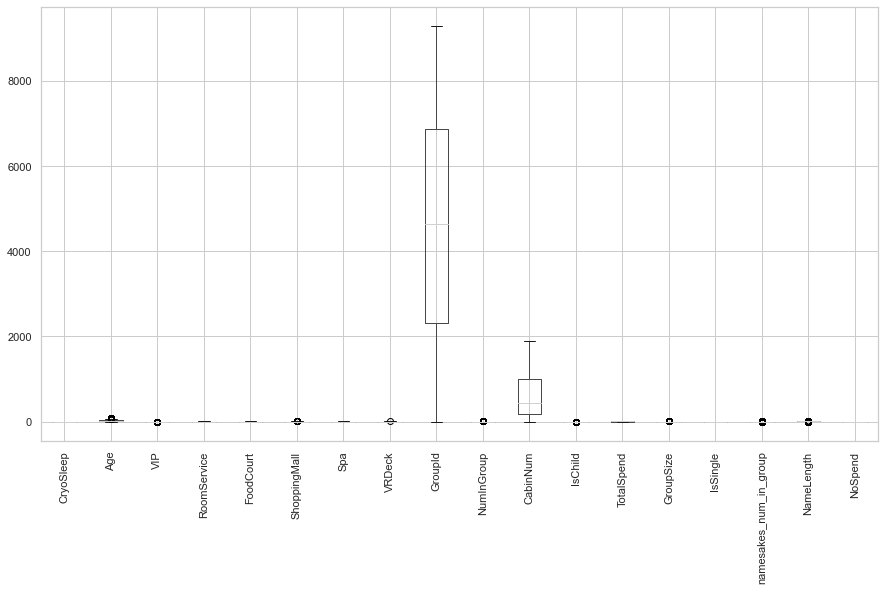

In [110]:
# numeric_columns.append('CabinDeck')

# Box Plot erzeugen
plt.figure(figsize=(15, 8))
X_train[numeric_columns].boxplot(rot=90)

<AxesSubplot:>

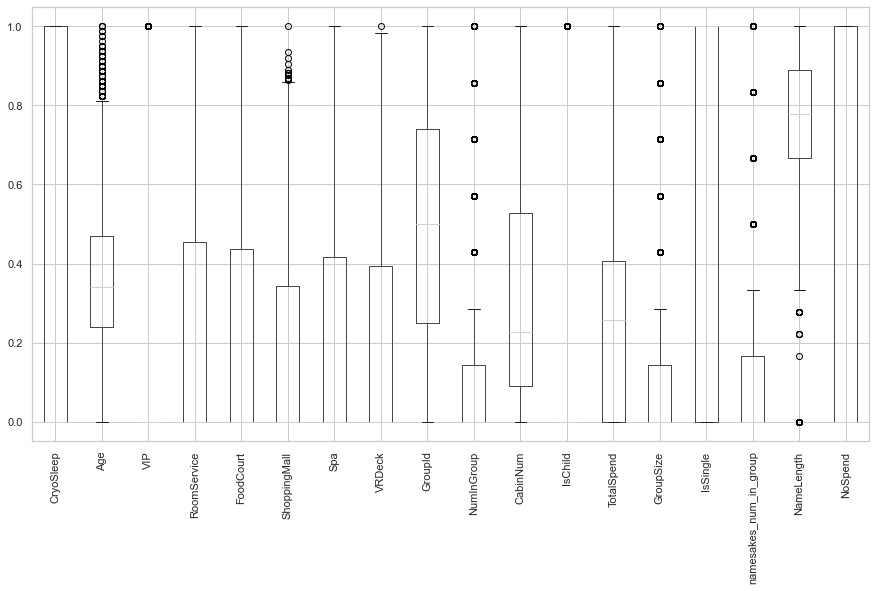

In [111]:
# numerische features skalieren
scaler = MinMaxScaler()
scaler.fit(X_train[numeric_columns])
X_train.loc[:, numeric_columns] = scaler.transform(X_train[numeric_columns])

# Box Plot erzeugen
plt.figure(figsize=(15, 8))
X_train.loc[:, numeric_columns].boxplot(rot=90)

In [112]:
X_train

x0_Earth  x0_Europa  x0_Mars  x1_55 Cancri e  x1_PSO J318.5-22  \
0          1.0        0.0      0.0             0.0               0.0   
1          1.0        0.0      0.0             0.0               0.0   
2          1.0        0.0      0.0             0.0               0.0   
3          1.0        0.0      0.0             0.0               0.0   
4          1.0        0.0      0.0             1.0               0.0   
...        ...        ...      ...             ...               ...   
6949       1.0        0.0      0.0             0.0               1.0   
6950       1.0        0.0      0.0             0.0               0.0   
6951       0.0        0.0      1.0             0.0               0.0   
6952       0.0        1.0      0.0             0.0               0.0   
6953       0.0        1.0      0.0             1.0               0.0   

      x1_TRAPPIST-1e  x2_O  x2_P  x2_S  x3_A  ...   GroupId  NumInGroup  \
0                1.0   0.0   0.0   1.0   0.0  ...  0.679815    0.142857   
1                1.0   0.0   0.0   1.0   0.0  ...  0.313288    0.142857   
2                1.0   0.0   0.0   1.0   0.0  ...  0.058950    0.000000   
3                1.0   0.0   0.0   1.0   0.0  ...  0.943636    0.000000   
4                0.0   0.0   1.0   0.0   0.0  ...  0.177066    0.000000   
...              ...   ...   ...   ...   ...  ...       ...         ...   
6949             0.0   0.0   0.0   1.0   0.0  ...  0.155620    0.000000   
6950             1.0   0.0   1.0   0.0   0.0  ...  0.106261    0.000000   
6951             1.0   0.0   0.0   1.0   0.0  ...  0.494773    0.285714   
6952             1.0   0.0   0.0   1.0   0.0  ...  0.650393    0.142857   
6953             0.0   0.0   1.0   0.0   0.0  ...  0.061429    0.000000   

      CabinNum  IsChild  TotalSpend  GroupSize  IsSingle  \
0     0.540984      1.0    0.000000   0.428571       0.0   
1     0.292438      1.0    0.437374   0.000000       1.0   
2     0.019038      0.0    0.294976   0.000000       1.0   
3     0.745108      0.0    0.381140   0.000000       1.0   
4     0.172924      1.0    0.195781   0.000000       1.0   
...        ...      ...         ...        ...       ...   
6949  0.116869      1.0    0.000000   0.000000       1.0   
6950  0.107879      1.0    0.406790   0.000000       1.0   
6951  0.455843      0.0    0.000000   0.428571       0.0   
6952  0.118985      1.0    0.497925   0.285714       0.0   
6953  0.011105      0.0    0.000000   0.571429       0.0   

      namesakes_num_in_group  NameLength  NoSpend  
0                   0.333333    0.833333      1.0  
1                   0.000000    0.888889      0.0  
2                   0.000000    0.777778      0.0  
3                   0.000000    0.722222      0.0  
4                   0.000000    0.888889      0.0  
...                      ...         ...      ...  
6949                0.000000    0.833333      1.0  
6950                0.000000    0.777778      0.0  
6951                0.500000    0.611111      1.0  
6952                0.333333    0.888889      0.0  
6953                0.666667    0.777778      1.0  

[6954 rows x 44 columns]

## Speicherplatz Optimierung

In [113]:
X_train.dtypes

x0_Earth                     float64
x0_Europa                    float64
x0_Mars                      float64
x1_55 Cancri e               float64
x1_PSO J318.5-22             float64
x1_TRAPPIST-1e               float64
x2_O                         float64
x2_P                         float64
x2_S                         float64
x3_A                         float64
x3_B                         float64
x3_C                         float64
x3_D                         float64
x3_E                         float64
x3_F                         float64
x3_G                         float64
x3_T                         float64
x4_Earth - 55 Cancri e       float64
x4_Earth - PSO J318.5-22     float64
x4_Earth - TRAPPIST-1e       float64
x4_Europa - 55 Cancri e      float64
x4_Europa - PSO J318.5-22    float64
x4_Europa - TRAPPIST-1e      float64
x4_Mars - 55 Cancri e        float64
x4_Mars - PSO J318.5-22      float64
x4_Mars - TRAPPIST-1e        float64
CryoSleep                    float64
A

In [114]:
X_train.memory_usage(deep= True)

Index                        319864
x0_Earth                      55632
x0_Europa                     55632
x0_Mars                       55632
x1_55 Cancri e                55632
x1_PSO J318.5-22              55632
x1_TRAPPIST-1e                55632
x2_O                          55632
x2_P                          55632
x2_S                          55632
x3_A                          55632
x3_B                          55632
x3_C                          55632
x3_D                          55632
x3_E                          55632
x3_F                          55632
x3_G                          55632
x3_T                          55632
x4_Earth - 55 Cancri e        55632
x4_Earth - PSO J318.5-22      55632
x4_Earth - TRAPPIST-1e        55632
x4_Europa - 55 Cancri e       55632
x4_Europa - PSO J318.5-22     55632
x4_Europa - TRAPPIST-1e       55632
x4_Mars - 55 Cancri e         55632
x4_Mars - PSO J318.5-22       55632
x4_Mars - TRAPPIST-1e         55632
CryoSleep                   

In [115]:
def memory_optimiz(df):
    print('------ memory_optimiz ------------')
    df_opti = df.apply(pd.to_numeric, downcast="float")
    
    reduction = (df.memory_usage(deep=True).sum()-df_opti.memory_usage(deep=True).sum())/df.memory_usage(deep=True).sum() *  100

    print(f"Reduction = {reduction:0.2f}%")
    
    return df_opti

In [116]:
X_train = memory_optimiz(X_train)

------ memory_optimiz ------------
Reduction = 44.22%


## Correlationsmatrix

<AxesSubplot:>

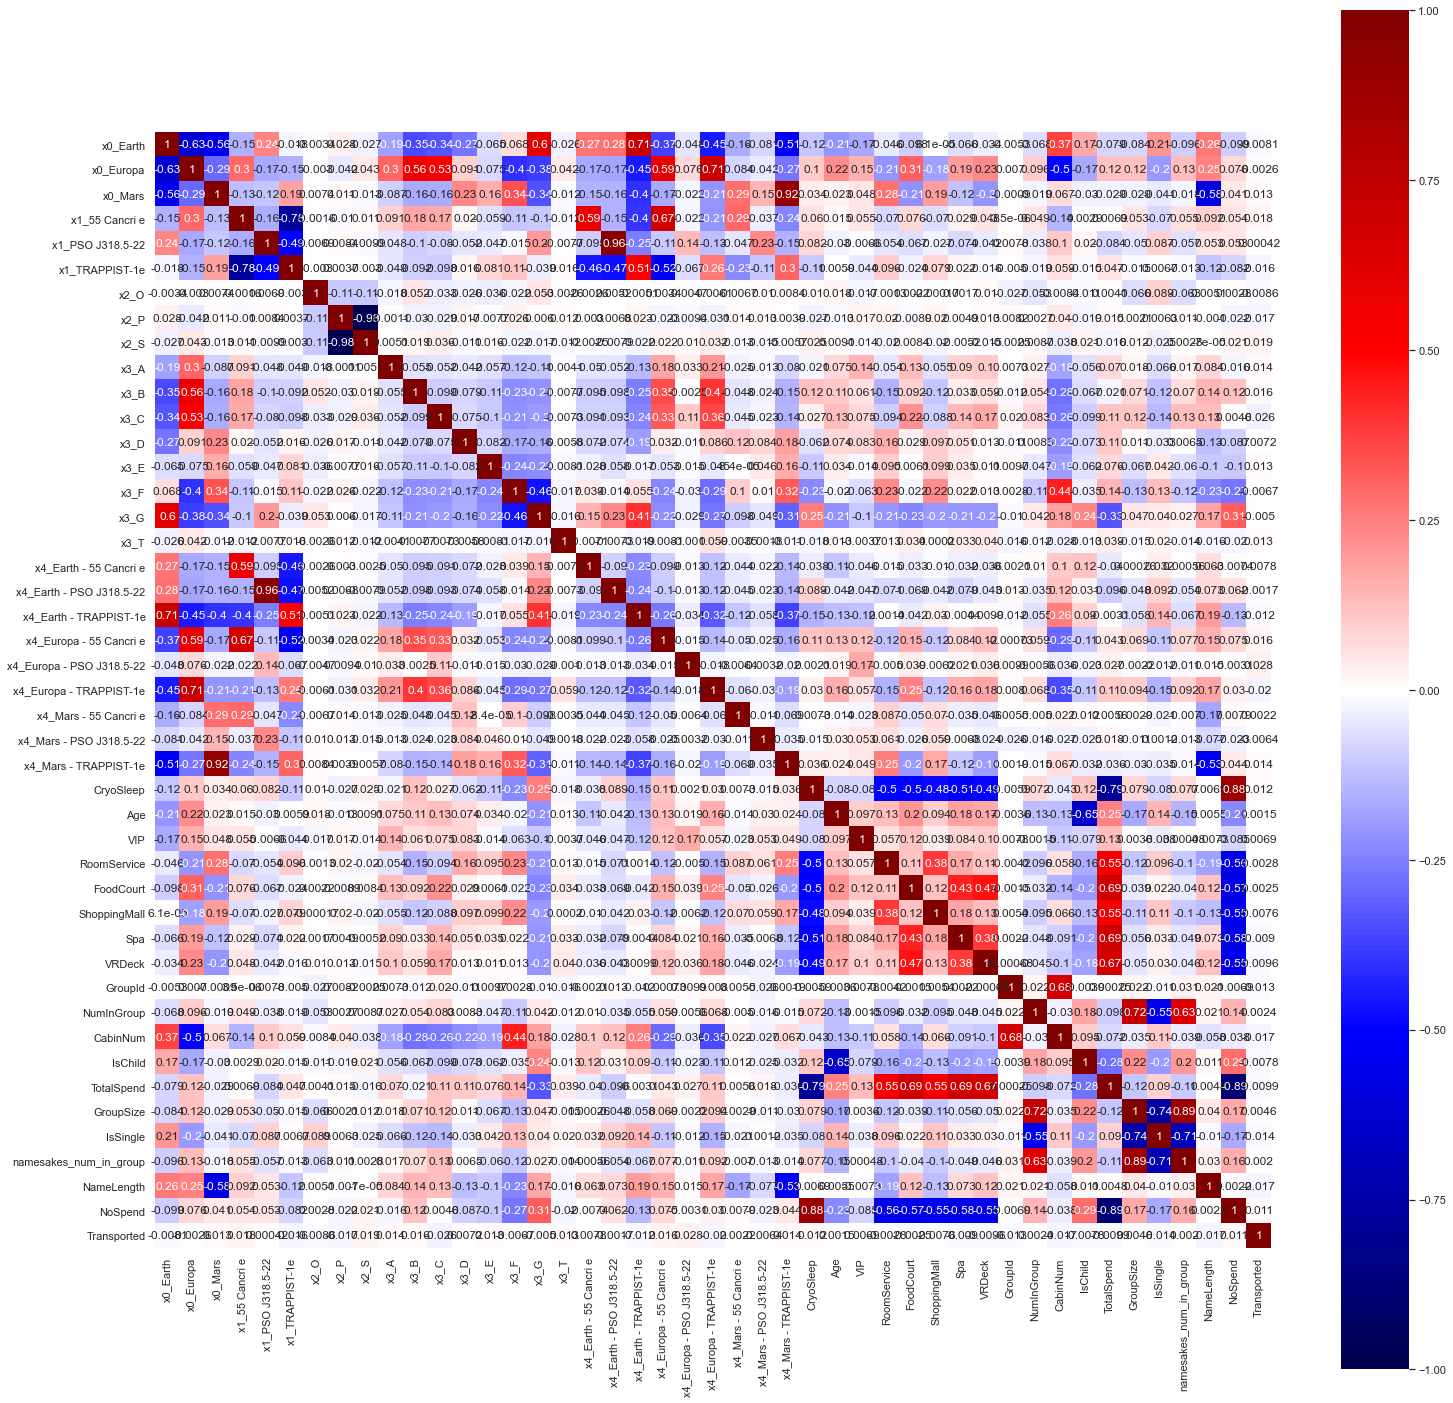

In [117]:
X_train_tmp = X_train.copy()
X_train_tmp['Transported'] = y_train

corrmat = X_train_tmp.corr()

fig = plt.figure(figsize=(25, 25))
sns.heatmap(corrmat, vmax=1, vmin=-1, square=True, cmap="seismic", annot=True)

## Test Daten Vorbereitung

In [118]:
def data_transform(df, source_data, *args):
    
    age_medians = []
    expenses_means = []
    df = new_features_create(df)
    
    df = HomePlanet_update(df, source_data)
    df= Destination_update(df)
    df = LastName_update(df)
    df = CabinDeck_update(df)   
    null_cabin_num_ind, df = CabinNum_update(df, source_data)
    df = CabinSide_update(df, source_data)
    df = VIP_update(df)
    df = CryoSleep_update(df)
      
    if len(args) == 0:
        age_medians = get_age_medians(df)
        expenses_means = get_expenses_means(df)
    else:
        age_medians = args[0]
        expenses_means = args[1]  
    
    df = Age_update(df, age_medians)
    df = Expenses_update(df, expenses_means)
        
    df = log_expenses(df)
    df = New_features_update(df)

    df.drop(['Cabin', 'PassengerId', 'Name', 'FirstName', 'LastName'], axis=1, inplace=True)
    
    df = bool_to_int(df)
    
    return df, age_medians, expenses_means

In [119]:
def encode_data(df, nominal_encoder, scaler):

    df_nominal = nominal_encoder.transform(df.loc[:, nominal_columns])
    df_nominal = pd.DataFrame(
        df_nominal,
        columns=nominal_encoder.get_feature_names(),
        index=df.index
    )
    df_nominal


    df = pd.concat((df_nominal, df.drop(columns=nominal_columns)), axis=1)


    df.loc[:, numeric_columns] = scaler.transform(df[numeric_columns])
    
    return df

In [120]:
X_test, am, em = data_transform(X_test, for_visual_df, age_medians_train, expenses_means_train)
X_test = encode_data(X_test, nominal_encoder, scaler)
X_test = memory_optimiz(X_test)


------ HomePlanet_update ------------
HomePlanet NULLs: 35
1. (after replacement through the Сabin) HomePlanet NULLs: 17
2. (after replacement through the Deck) HomePlanet NULLs: 9
3. (after replacement through the LastName) HomePlanet NULLs: 1
4. (after replacement through the Destination): 0
5. (after replacement by the most common value) HomePlanet NULLs: 0
------ Destination_update ------------
Destination NULLs: 29
(after replacement by the most common value) Destination NULLs: 0
------ LastName_update ------------
LastName NULLs: 35
(1554, 2)
(after update) LastName NULLs: 29
namesakes_num_in_group NULLs: 29
namesakes_num_in_group NULLs: 0
------ CabinDeck_update ------------
CabinDeck NULLs: 42
(after update throw GroupId) CabinDeck NULLs: 30
(after update throw HomePlanet) CabinDeck NULLs: 0
------ CabinNum_update ------------
CabinNum NULLs: 42
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
B (10, 1)
F (8, 1)
G (24, 1)
CabinNum NULLs: 0
------ CabinSide_update ------------
CabinSide

In [121]:
data = pd.read_csv("train.csv", sep=',', engine='python')

In [122]:
X, age_medians_all, expenses_means_all = data_transform(data.drop(columns="Transported"), for_visual_df)
y = data["Transported"].astype(int)

------ HomePlanet_update ------------
HomePlanet NULLs: 201
1. (after replacement through the Сabin) HomePlanet NULLs: 111
2. (after replacement through the Deck) HomePlanet NULLs: 63
3. (after replacement through the LastName) HomePlanet NULLs: 8
4. (after replacement through the Destination): 0
5. (after replacement by the most common value) HomePlanet NULLs: 0
------ Destination_update ------------
Destination NULLs: 182
(after replacement by the most common value) Destination NULLs: 0
------ LastName_update ------------
LastName NULLs: 200
(6113, 2)
(after update) LastName NULLs: 104
namesakes_num_in_group NULLs: 104
namesakes_num_in_group NULLs: 0
------ CabinDeck_update ------------
CabinDeck NULLs: 199
(after update throw GroupId) CabinDeck NULLs: 99
(after update throw HomePlanet) CabinDeck NULLs: 0
------ CabinNum_update ------------
CabinNum NULLs: 199
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
A (6, 1)
B (38, 1)
C (14, 1)
D (9, 1)
E (9, 1)
F (36, 1)
G (87, 1)
CabinNum NULLs: 0

In [123]:
def encode_all_data(df):
    numeric_selector = make_column_selector(dtype_include=np.number)
    numeric_columns = numeric_selector(df)
    print(numeric_columns)

    
    nominal_columns = ["HomePlanet", "Destination", 'CabinSide', 'CabinDeck', 'Route']
    nominal_categories = [list(sorted(df[column].unique())) for column in nominal_columns]

    print(nominal_categories)

    nominal_encoder = OneHotEncoder(categories=nominal_categories, sparse=False)
    nominal_encoder.fit(df.loc[:, nominal_columns])
    df_nominal = nominal_encoder.transform(df.loc[:, nominal_columns])
    df_nominal = pd.DataFrame(
        df_nominal,
        columns=nominal_encoder.get_feature_names(),
        index=df.index
    )
    
    df = pd.concat((df_nominal, df.drop(columns=nominal_columns)), axis=1)

    # numerische features skalieren
    scaler = MinMaxScaler()
    scaler.fit(df[numeric_columns])
    df.loc[:, numeric_columns] = scaler.transform(df[numeric_columns])
    
    return df, nominal_encoder, scaler

In [126]:
X, nominal_encoder_all, scaler_all = encode_all_data(X)

X = memory_optimiz(X)

['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupId', 'NumInGroup', 'CabinNum', 'IsChild', 'TotalSpend', 'GroupSize', 'IsSingle', 'namesakes_num_in_group', 'NameLength', 'NoSpend']
[['Earth', 'Europa', 'Mars'], ['55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e'], ['O', 'P', 'S'], ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], ['Earth - 55 Cancri e', 'Earth - PSO J318.5-22', 'Earth - TRAPPIST-1e', 'Europa - 55 Cancri e', 'Europa - PSO J318.5-22', 'Europa - TRAPPIST-1e', 'Mars - 55 Cancri e', 'Mars - PSO J318.5-22', 'Mars - TRAPPIST-1e']]
------ memory_optimiz ------------
Reduction = 45.08%


## Logistic Regression

In [127]:
roc_curves = {}
model_acc = {}

In [128]:
def get_roc_curve(y_test, y_test_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
    rel = {}
    for i in range(0, len(fpr)):
        rel[i] = tpr[i] + (1 - fpr[i])
    
    best_threshold_ind = max(rel, key=rel.get)


    print('tpr =', tpr[best_threshold_ind], 'fpr =', fpr[best_threshold_ind], 'threshold =', thresholds[best_threshold_ind] )
  
    return fpr, tpr, best_threshold_ind, thresholds[best_threshold_ind]

In [129]:
def plot_roc_curve(fpr, tpr, best_threshold_ind):
    fig, axs = plt.subplots(figsize=(10, 6))


    plt.hlines(y=tpr[best_threshold_ind], xmin=0, xmax=fpr[best_threshold_ind], linestyles='--')
    plt.vlines(x=fpr[best_threshold_ind], ymin=0, ymax=tpr[best_threshold_ind], linestyles='--')

    plt.plot([0, 1], [0, 1], linestyle='dashed', color='red')
    plt.plot(fpr, tpr)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')

In [159]:
param_grid = {
    'penalty': ['l1','l2'],
    'C': [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2],
    'max_iter': [50, 100, 150]
}

logisticRegression_gridsearch_hp_tuning = GridSearchCV(
        LogisticRegression(),
        param_grid=param_grid,
      #  scoring="accuracy",
        n_jobs=-1,
        verbose = 4
)

logisticRegression_gridsearch_hp_tuning.fit(X_train, y_train)
print(logisticRegression_gridsearch_hp_tuning.best_params_)

print("best_score = ", logisticRegression_gridsearch_hp_tuning.best_score_)
print('acc X_train = ', logisticRegression_gridsearch_hp_tuning.score(X_train, y_train))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\natalie\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.77250578        nan 0.77250578        nan 0.77250578
        nan 0.77509416        nan 0.77509416        nan 0.77509416
        nan 0.77682026        nan 0.77696404        nan 0.77696404
        nan 0.7772516         nan 0.77696394        nan 0.7772516
        nan 0.77696394        nan 0.77696394        nan 0.77696394
        nan 0.77696383        nan 0.7772515         nan 0.7772515
        nan 0.77696383        nan 0.77710761        nan 0.77739528
        nan 0.77667606        nan 0.77696373        nan 0.77696373]
  warnings.warn(


{'C': 1.5, 'max_iter': 150, 'penalty': 'l2'}
best_score =  0.7773952800376522
acc X_train =  0.7788323267184354


In [130]:
lg_reg_mod = LogisticRegression(C = 1.5, max_iter = 150, penalty = 'l2').fit(X_train, y_train)
print('Acc Train =', round(lg_reg_mod.score(X_train, y_train) * 100, 2))
print('Acc Test =', round(lg_reg_mod.score(X_test, y_test) * 100, 2))

model_acc['LogisticRegression'] = round(lg_reg_mod.score(X_test, y_test) * 100, 2)

y_test_pred_prob = pd.DataFrame(lg_reg_mod.predict_proba(X_test)[:, 1])
#y_test_pred_prob

Acc Train = 77.88
Acc Test = 78.26


C:\Users\natalie\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


tpr = 0.7839721254355401 fpr = 0.21298405466970388 threshold = 0.5493525932671351


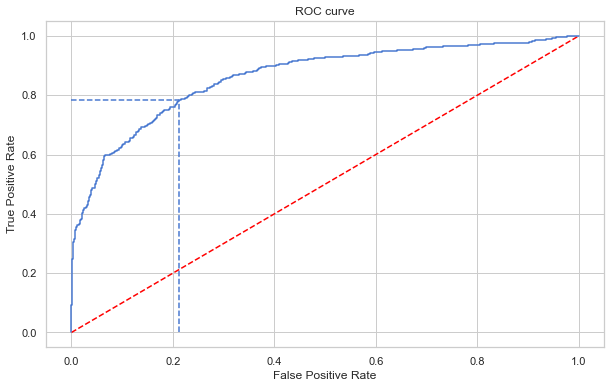

In [131]:
fpr, tpr, best_threshold_ind, best_threshold = get_roc_curve(y_test, y_test_pred_prob)
roc_curves['LogisticRegression'] = (fpr, tpr, best_threshold_ind)
plot_roc_curve(fpr, tpr, best_threshold_ind)

In [132]:
# pr, re, thres = precision_recall_curve( y_test, y_test_pred_prob)

# fig, axs = plt.subplots(figsize=(12, 6))
# plt.plot(re, pr)
# plt.xlabel('recall')
# plt.ylabel('precision')

In [133]:
#y_test_pred_prob

y_test_pred = y_test_pred_prob.applymap(lambda x: 1 if x > best_threshold else 0)
y_test_pred
print('ACC with threshold', round(best_threshold, 3), '=', round(accuracy_score(y_test, y_test_pred) *100, 5))

ACC with threshold 0.549 = 78.49339


## DecisionTreeClassifier

In [166]:
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_leaf': [1, 3, 5, 8]
}

decisionTreeClassifier_gridsearch_hp_tuning = GridSearchCV(
        DecisionTreeClassifier(),
        param_grid=param_grid,
      #  scoring="accuracy",
        n_jobs=-1,
        verbose = 4
)

decisionTreeClassifier_gridsearch_hp_tuning.fit(X_train, y_train)
print(decisionTreeClassifier_gridsearch_hp_tuning.best_params_)

print("best_score = ", decisionTreeClassifier_gridsearch_hp_tuning.best_score_)
print('acc X_train = ', decisionTreeClassifier_gridsearch_hp_tuning.score(X_train, y_train))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'max_depth': 5, 'min_samples_leaf': 3}
best_score =  0.7802724606799105
acc X_train =  0.7988208225481737


In [134]:
dt_mod = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 3).fit(X_train, y_train)
print('Acc Train =', round(dt_mod.score(X_train, y_train) * 100, 2))
print('Acc Test =', round(dt_mod.score(X_test, y_test) * 100, 2))

model_acc['DecisionTreeClassifier'] = round(dt_mod.score(X_test, y_test) * 100, 2)

y_test_pred_prob = pd.DataFrame(dt_mod.predict_proba(X_test)[:, 1])

Acc Train = 79.88
Acc Test = 78.55


tpr = 0.8130081300813008 fpr = 0.22209567198177677 threshold = 0.5378151260504201


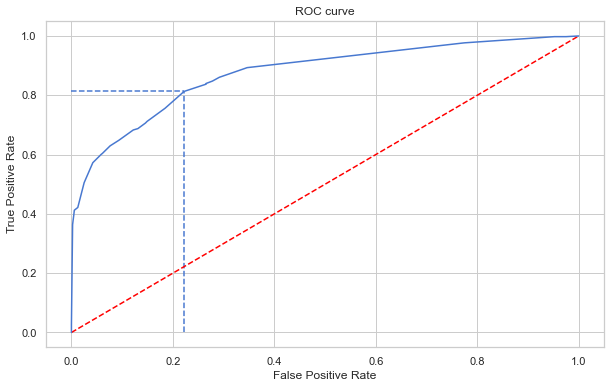

In [135]:
fpr, tpr, best_threshold_ind, best_threshold = get_roc_curve(y_test, y_test_pred_prob)
roc_curves['DecisionTreeClassifier'] = (fpr, tpr, best_threshold_ind)
plot_roc_curve(fpr, tpr, best_threshold_ind)

In [136]:
y_test_pred = y_test_pred_prob.applymap(lambda x: 1 if x > best_threshold else 0)
y_test_pred
print('ACC with threshold', round(best_threshold, 3), '=', round(accuracy_score(y_test, y_test_pred) *100, 5))

ACC with threshold 0.538 = 78.6084


## RandomForestClassifier

In [171]:
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_leaf': [1, 3, 5, 8],
    'n_estimators': [50, 100, 150, 200, 250, 300]
}

randomForestClassifier_gridsearch_hp_tuning = GridSearchCV(
        RandomForestClassifier(),
        param_grid=param_grid,
      #  scoring="accuracy",
        n_jobs=-1,
        verbose = 4
)

randomForestClassifier_gridsearch_hp_tuning.fit(X_train, y_train)
print(randomForestClassifier_gridsearch_hp_tuning.best_params_)

print("best_score = ", randomForestClassifier_gridsearch_hp_tuning.best_score_)
print('acc X_train = ', randomForestClassifier_gridsearch_hp_tuning.score(X_train, y_train))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 200}
best_score =  0.8004036224650761
acc X_train =  0.8651136036813345


In [137]:
rf_mod = RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators = 200)
rf_mod.fit(X_train, y_train)

print('Acc Train =', round(rf_mod.score(X_train, y_train) * 100, 2))
print('Acc Test =', round(rf_mod.score(X_test, y_test) * 100, 2))


# rf_mod.fit(X_, y)
# print('Acc Train =', round(rf_mod.score(X, y) * 100, 2))
model_acc['RandomForestClassifier'] = round(rf_mod.score(X_test, y_test) * 100, 2)

d = {'Features': X_train.columns, 'importance': rf_mod.feature_importances_*100}
features_imp_df = pd.DataFrame(data=d).sort_values('importance', ascending=False)
features_imp_df

Acc Train = 86.38
Acc Test = 80.68


Features  importance
38                 TotalSpend   12.787465
43                    NoSpend    9.161125
26                  CryoSleep    8.376497
32                        Spa    8.139370
29                RoomService    8.033237
30                  FoodCourt    7.460719
33                     VRDeck    7.294368
31               ShoppingMall    5.478737
36                   CabinNum    4.259844
34                    GroupId    3.922740
27                        Age    2.924515
0                    x0_Earth    2.200620
42                 NameLength    1.905505
1                   x0_Europa    1.778460
15                       x3_G    1.488208
13                       x3_E    1.449049
19     x4_Earth - TRAPPIST-1e    1.445424
14                       x3_F    1.294985
8                        x2_S    1.156718
7                        x2_P    1.094929
41     namesakes_num_in_group    0.846635
39                  GroupSize    0.790603
35                 NumInGroup    0.667360
25      x4_Mars - TRAPPIST-1e    0.657564
22    x4_Europa - TRAPPIST-1e    0.631214
2                     x0_Mars    0.604532
11                       x3_C    0.552146
10                       x3_B    0.505894
20    x4_Europa - 55 Cancri e    0.457576
37                    IsChild    0.446559
5              x1_TRAPPIST-1e    0.444906
3              x1_55 Cancri e    0.303726
40                   IsSingle    0.284980
4            x1_PSO J318.5-22    0.244606
17     x4_Earth - 55 Cancri e    0.230199
18   x4_Earth - PSO J318.5-22    0.209381
12                       x3_D    0.179163
9                        x3_A    0.101463
28                        VIP    0.067575
23      x4_Mars - 55 Cancri e    0.051822
24    x4_Mars - PSO J318.5-22    0.036250
6                        x2_O    0.031538
21  x4_Europa - PSO J318.5-22    0.001795
16                       x3_T    0.000000

tpr = 0.8130081300813008 fpr = 0.22209567198177677 threshold = 0.5378151260504201


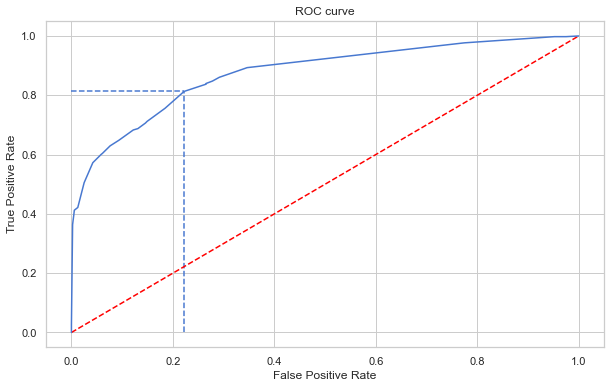

In [138]:
fpr, tpr, best_threshold_ind, best_threshold = get_roc_curve(y_test, y_test_pred_prob)
roc_curves['RandomForestClassifier'] = (fpr, tpr, best_threshold_ind)
plot_roc_curve(fpr, tpr, best_threshold_ind)

In [139]:
y_test_pred = y_test_pred_prob.applymap(lambda x: 1 if x > best_threshold else 0)
y_test_pred
print('ACC with threshold', round(best_threshold, 3), '=', round(accuracy_score(y_test, y_test_pred) *100, 5))

ACC with threshold 0.538 = 78.6084


## GradientBoostingClassifier

In [176]:
# min_samples_leaf=[3, 5, 8]

param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.5],
    "n_estimators": [50, 100, 150, 200, 250],
    'max_depth' : [3, 5, 8],
    'min_samples_leaf' : [1, 3, 5, 8]
}


gradientBoostingClassifier_gridsearch_hp_tuning = GridSearchCV(
        GradientBoostingClassifier(),
        param_grid=param_grid,
      #  scoring="accuracy",
        n_jobs=-1,
        verbose = 2
)

gradientBoostingClassifier_gridsearch_hp_tuning.fit(X_train, y_train)
print(gradientBoostingClassifier_gridsearch_hp_tuning.best_params_)

print("best_score = ", gradientBoostingClassifier_gridsearch_hp_tuning.best_score_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
{'learning_rate': 0.05, 'max_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 100}
best_score =  0.8068739946935335


In [140]:
#gb_mod = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3)#, min_samples_leaf=3) 
gb_mod = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=8, min_samples_leaf=3) 
gb_mod.fit(X_train, y_train)

print('Acc Train =', round(gb_mod.score(X_train, y_train) * 100, 2))
print('Acc Test =', round(gb_mod.score(X_test, y_test) * 100, 2))

model_acc['GradientBoostingClassifier'] = round(gb_mod.score(X_test, y_test) * 100, 2)

Acc Train = 94.66
Acc Test = 80.62


tpr = 0.7491289198606271 fpr = 0.1264236902050114 threshold = 0.6141767991231261


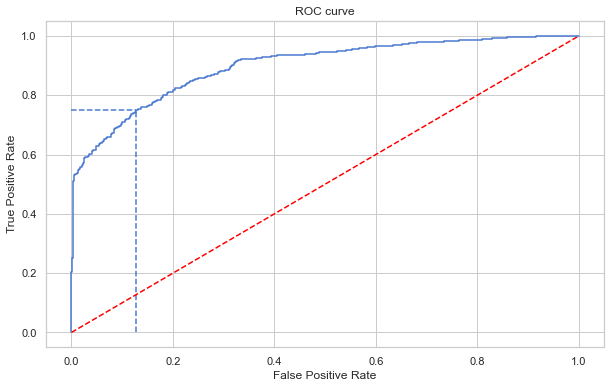

In [141]:
y_test_pred_prob = pd.DataFrame(gb_mod.predict_proba(X_test)[:, 1])

fpr, tpr, best_threshold_ind, best_threshold = get_roc_curve(y_test, y_test_pred_prob)
roc_curves['GradientBoostingClassifier'] = (fpr, tpr, best_threshold_ind)
plot_roc_curve(fpr, tpr, best_threshold_ind)

In [142]:
y_test_pred = y_test_pred_prob.applymap(lambda x: 1 if x > best_threshold else 0)
y_test_pred
print('ACC with threshold', round(best_threshold, 3), '=', round(accuracy_score(y_test, y_test_pred) *100, 5))

ACC with threshold 0.614 = 81.13859


In [143]:
# gb_mod_all = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, min_samples_leaf=3) 
# gb_mod_all.fit(X, y)

# print('Acc Train =', round(gb_mod_all.score(X, y) * 100, 2))

# y_pred_prob = pd.DataFrame(gb_mod_all.predict_proba(X)[:, 1])
# best_threshold = get_roc_curve (y, y_pred_prob)

## PCA

In [144]:
pca_model = PCA()
pca_model.fit(X)
pca_model.explained_variance_

array([8.02524805e-01, 7.09403515e-01, 5.50627232e-01, 4.92060095e-01,
       4.18870270e-01, 2.90213823e-01, 2.11794287e-01, 1.95547730e-01,
       1.43445373e-01, 1.21408984e-01, 1.10013269e-01, 1.02128550e-01,
       9.07443091e-02, 6.79056942e-02, 5.48367649e-02, 4.73718680e-02,
       4.51837294e-02, 4.16513123e-02, 4.08019461e-02, 3.78156416e-02,
       3.73843946e-02, 3.43050286e-02, 2.15274561e-02, 1.77028868e-02,
       1.71423294e-02, 1.63563993e-02, 1.42646180e-02, 1.26813771e-02,
       1.13535104e-02, 8.98689125e-03, 5.74328890e-03, 4.39007720e-03,
       3.51034966e-03, 6.49406400e-04, 1.00475380e-13, 2.09532861e-14,
       1.42453357e-14, 6.18282975e-15, 2.04101864e-15, 1.73846969e-15,
       1.73846969e-15, 1.73846969e-15, 1.29800896e-15, 7.46413056e-16],
      dtype=float32)

Text(0, 0.5, 'Explained Variance')

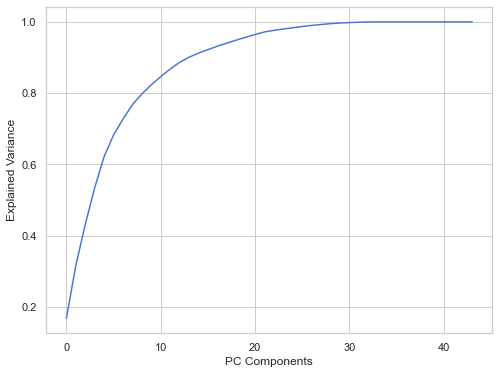

In [145]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca_model.explained_variance_ratio_))


plt.xlabel("PC Components")
plt.ylabel("Explained Variance")

In [146]:
pca_model_90 = PCA(n_components=2)
pca_model_90.fit(X)

X_train_auto_reduced = pca_model_90.transform(X)
X_train_auto_reduced.shape


(8693, 2)

Text(0, 0.5, 'Component 1')

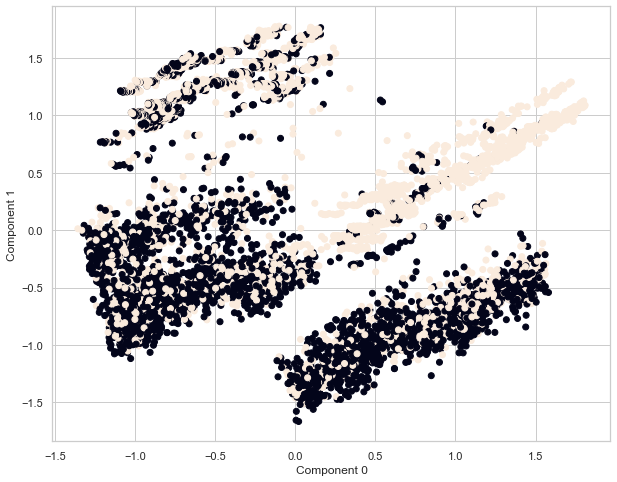

In [147]:
plt.figure(figsize=(10,8))

plt.scatter(X_train_auto_reduced[:, 0], X_train_auto_reduced[:, 1], c=y)

plt.xlabel("Component 0")
plt.ylabel("Component 1")

In [148]:
# X_train_auto_reduced = pd.DataFrame(X_train_auto_reduced)

# X_pca = pd.concat((X, X_train_auto_reduced), axis=1)
# X_pca

In [149]:
# pca_model_90.fit(X_test)

# X_test_auto_reduced = pca_model_90.transform(X_test)
# X_test_auto_reduced.shape

# X_test_auto_reduced = pd.DataFrame(X_test_auto_reduced)

# X_test_pca = pd.concat((X_test, X_test_auto_reduced), axis=1)
# X_test_pca

In [150]:
# gb_with_pca_mod = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=4, min_samples_leaf=3) 
# gb_with_pca_mod.fit(X_pca, y)

# print('Acc Train =', round(gb_with_pca_mod.score(X_pca, y) * 100, 2))
# print('Acc Test =', round(gb_with_pca_mod.score(X_test_pca, y_test) * 100, 2))

## SVM

In [187]:
param_grid = {
    'C': [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

SVC_gridsearch_hp_tuning = GridSearchCV(
        SVC(),
        param_grid=param_grid,
      #  scoring="accuracy",
        n_jobs=-1,
        verbose = 2
)

SVC_gridsearch_hp_tuning.fit(X_train, y_train)
print(SVC_gridsearch_hp_tuning.best_params_)

print("best_score = ", SVC_gridsearch_hp_tuning.best_score_)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
{'C': 1.5, 'gamma': 'scale', 'kernel': 'poly'}
best_score =  0.7929262628718018


In [151]:
svc_mod = SVC(C = 1.5, gamma = 'scale', kernel = 'poly', probability = True)
svc_mod.fit(X_train, y_train)

print('Acc Train =', round(svc_mod.score(X_train, y_train) * 100, 2))
print('Acc Test =', round(svc_mod.score(X_test, y_test) * 100, 2))

model_acc['SVC'] = round(svc_mod.score(X_test, y_test) * 100, 2)


Acc Train = 81.71
Acc Test = 80.05


tpr = 0.8478513356562137 fpr = 0.24031890660592256 threshold = 0.4303741975527282


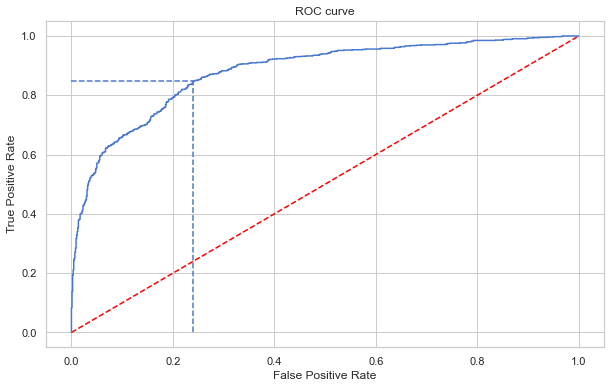

In [152]:
y_test_pred_prob = pd.DataFrame(svc_mod.predict_proba(X_test)[:, 1])

fpr, tpr, best_threshold_ind, best_threshold = get_roc_curve(y_test, y_test_pred_prob)
roc_curves['SVC'] = (fpr, tpr, best_threshold_ind)
plot_roc_curve(fpr, tpr, best_threshold_ind)

In [153]:
y_test_pred = y_test_pred_prob.applymap(lambda x: 1 if x > best_threshold else 0)
y_test_pred
print('ACC with threshold', round(best_threshold, 3), '=', round(accuracy_score(y_test, y_test_pred) *100, 5))

ACC with threshold 0.43 = 80.27602


## KNeighborsClassifier

In [191]:
param_grid = {
    'n_neighbors': [2, 3, 5, 8, 10, 12],
    'p': [1, 2]
}

kNeighborsClassifier_gridsearch_hp_tuning = GridSearchCV(
        KNeighborsClassifier(),
        param_grid=param_grid,
      #  scoring="accuracy",
        n_jobs=-1,
        verbose = 2
)

kNeighborsClassifier_gridsearch_hp_tuning.fit(X_train, y_train)
print(kNeighborsClassifier_gridsearch_hp_tuning.best_params_)

print("best_score = ", kNeighborsClassifier_gridsearch_hp_tuning.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'n_neighbors': 10, 'p': 2}
best_score =  0.7562560964887328


In [154]:
kn_mod = KNeighborsClassifier(n_neighbors=10, p=2)
kn_mod.fit(X_train, y_train)

print('Acc Train =', round(kn_mod.score(X_train, y_train) * 100, 2))
print('Acc Test =', round(kn_mod.score(X_test, y_test) * 100, 2))

model_acc['KNeighborsClassifier'] = round(kn_mod.score(X_test, y_test) * 100, 2)

Acc Train = 80.1
Acc Test = 77.34


tpr = 0.6968641114982579 fpr = 0.15148063781321183 threshold = 0.6


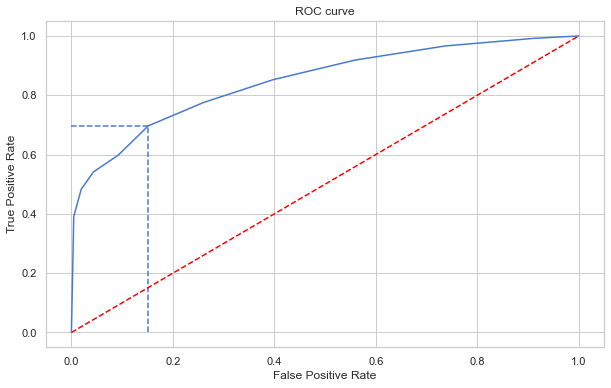

In [155]:
y_test_pred_prob = pd.DataFrame(kn_mod.predict_proba(X_test)[:, 1])

fpr, tpr, best_threshold_ind, best_threshold = get_roc_curve(y_test, y_test_pred_prob)
roc_curves['KNeighborsClassifier'] = (fpr, tpr, best_threshold_ind)
plot_roc_curve(fpr, tpr, best_threshold_ind)

In [156]:
y_test_pred = y_test_pred_prob.applymap(lambda x: 1 if x > best_threshold else 0)
y_test_pred
print('ACC with threshold', round(best_threshold, 3), '=', round(accuracy_score(y_test, y_test_pred) *100, 5))

ACC with threshold 0.6 = 75.44566


## XGBClassifier

In [195]:
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.5],
    "n_estimators": [50, 100, 150, 200, 250],
    'max_depth' : [3, 5, 8]
}


XGBClassifier_gridsearch_hp_tuning = GridSearchCV(
        XGBClassifier(),
        param_grid=param_grid,
      #  scoring="accuracy",
        n_jobs=-1,
        verbose = 2
)

XGBClassifier_gridsearch_hp_tuning.fit(X_train, y_train)
print(XGBClassifier_gridsearch_hp_tuning.best_params_)

print("best_score = ", XGBClassifier_gridsearch_hp_tuning.best_score_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
best_score =  0.8078803614189883


In [157]:
xgb_mod = XGBClassifier(n_estimators=150, learning_rate=0.1, max_depth=5)
xgb_mod.fit(X_train, y_train)

print('Acc Train =', round(xgb_mod.score(X_train, y_train) * 100, 2))
print('Acc Test =', round(xgb_mod.score(X_test, y_test) * 100, 2))

model_acc['XGBClassifier'] = round(xgb_mod.score(X_test, y_test) * 100, 2)

Acc Train = 88.37
Acc Test = 82.06


tpr = 0.835075493612079 fpr = 0.19248291571753987 threshold = 0.50029385


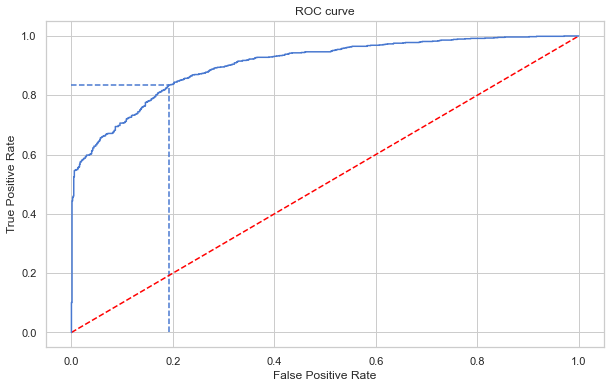

In [158]:
y_test_pred_prob = pd.DataFrame(xgb_mod.predict_proba(X_test)[:, 1])

fpr, tpr, best_threshold_ind, best_threshold = get_roc_curve(y_test, y_test_pred_prob)
roc_curves['XGBClassifier'] = (fpr, tpr, best_threshold_ind)
plot_roc_curve(fpr, tpr, best_threshold_ind)

In [159]:
y_test_pred = y_test_pred_prob.applymap(lambda x: 1 if x > best_threshold else 0)
y_test_pred
print('ACC with threshold', round(best_threshold, 3), '=', round(accuracy_score(y_test, y_test_pred) *100, 5))

ACC with threshold 0.5 = 82.05865


In [160]:
# xgb_mod = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)
# xgb_mod.fit(X, y)

# print('Acc Train =', round(xgb_mod.score(X, y) * 100, 2))

## CatBoostClassifier

In [161]:
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.5],
    "n_estimators": [100, 200, 300, 400, 500],
    'max_depth' : [3, 5, 8]
}


catBoostClassifier_gridsearch_hp_tuning = GridSearchCV(
        CatBoostClassifier(),
        param_grid=param_grid,
      #  scoring="accuracy",
        n_jobs=-1,
        verbose = 2
)

catBoostClassifier_gridsearch_hp_tuning.fit(X_train, y_train)
print(catBoostClassifier_gridsearch_hp_tuning.best_params_)

print("best_score = ", catBoostClassifier_gridsearch_hp_tuning.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
0:	learn: 0.6716945	total: 150ms	remaining: 59.7s
1:	learn: 0.6499350	total: 154ms	remaining: 30.6s
2:	learn: 0.6315790	total: 158ms	remaining: 20.9s
3:	learn: 0.6153583	total: 162ms	remaining: 16s
4:	learn: 0.6041371	total: 166ms	remaining: 13.1s
5:	learn: 0.5895787	total: 170ms	remaining: 11.2s
6:	learn: 0.5775957	total: 174ms	remaining: 9.75s
7:	learn: 0.5693777	total: 178ms	remaining: 8.7s
8:	learn: 0.5605364	total: 181ms	remaining: 7.88s
9:	learn: 0.5495399	total: 185ms	remaining: 7.23s
10:	learn: 0.5419091	total: 189ms	remaining: 6.7s
11:	learn: 0.5348777	total: 193ms	remaining: 6.25s
12:	learn: 0.5288474	total: 198ms	remaining: 5.88s
13:	learn: 0.5236525	total: 202ms	remaining: 5.56s
14:	learn: 0.5166329	total: 206ms	remaining: 5.28s
15:	learn: 0.5119789	total: 210ms	remaining: 5.04s
16:	learn: 0.5085913	total: 214ms	remaining: 4.82s
17:	learn: 0.5043704	total: 218ms	remaining: 4.63s
18:	learn: 0.5006085	total: 222ms	

176:	learn: 0.3683170	total: 897ms	remaining: 1.13s
177:	learn: 0.3679144	total: 901ms	remaining: 1.12s
178:	learn: 0.3675519	total: 905ms	remaining: 1.12s
179:	learn: 0.3673769	total: 910ms	remaining: 1.11s
180:	learn: 0.3670660	total: 914ms	remaining: 1.1s
181:	learn: 0.3667333	total: 918ms	remaining: 1.1s
182:	learn: 0.3663557	total: 923ms	remaining: 1.09s
183:	learn: 0.3660886	total: 927ms	remaining: 1.09s
184:	learn: 0.3658821	total: 931ms	remaining: 1.08s
185:	learn: 0.3654335	total: 935ms	remaining: 1.08s
186:	learn: 0.3652691	total: 939ms	remaining: 1.07s
187:	learn: 0.3648220	total: 944ms	remaining: 1.06s
188:	learn: 0.3645424	total: 949ms	remaining: 1.06s
189:	learn: 0.3643225	total: 953ms	remaining: 1.05s
190:	learn: 0.3640867	total: 957ms	remaining: 1.05s
191:	learn: 0.3638255	total: 962ms	remaining: 1.04s
192:	learn: 0.3633762	total: 966ms	remaining: 1.03s
193:	learn: 0.3630103	total: 970ms	remaining: 1.03s
194:	learn: 0.3626850	total: 974ms	remaining: 1.02s
195:	learn: 0.

357:	learn: 0.3187892	total: 1.65s	remaining: 193ms
358:	learn: 0.3185992	total: 1.65s	remaining: 189ms
359:	learn: 0.3183137	total: 1.66s	remaining: 184ms
360:	learn: 0.3180807	total: 1.66s	remaining: 180ms
361:	learn: 0.3178459	total: 1.67s	remaining: 175ms
362:	learn: 0.3176292	total: 1.67s	remaining: 170ms
363:	learn: 0.3174505	total: 1.67s	remaining: 166ms
364:	learn: 0.3171940	total: 1.68s	remaining: 161ms
365:	learn: 0.3170198	total: 1.68s	remaining: 156ms
366:	learn: 0.3168269	total: 1.69s	remaining: 152ms
367:	learn: 0.3166292	total: 1.69s	remaining: 147ms
368:	learn: 0.3164733	total: 1.7s	remaining: 142ms
369:	learn: 0.3163442	total: 1.7s	remaining: 138ms
370:	learn: 0.3162483	total: 1.7s	remaining: 133ms
371:	learn: 0.3160509	total: 1.71s	remaining: 129ms
372:	learn: 0.3158677	total: 1.71s	remaining: 124ms
373:	learn: 0.3157201	total: 1.72s	remaining: 119ms
374:	learn: 0.3154824	total: 1.72s	remaining: 115ms
375:	learn: 0.3153189	total: 1.73s	remaining: 110ms
376:	learn: 0.3

In [162]:
cbc_mod = CatBoostClassifier(n_estimators=400, learning_rate=0.05, max_depth=5)

cbc_mod.fit(X_train, y_train)

print('Acc Train =', round(cbc_mod.score(X_train, y_train) * 100, 2))
print('Acc Test =', round(cbc_mod.score(X_test, y_test) * 100, 2))

model_acc['CatBoostClassifier'] = round(cbc_mod.score(X_test, y_test) * 100, 2)

0:	learn: 0.6716945	total: 17.2ms	remaining: 6.85s
1:	learn: 0.6499350	total: 21.4ms	remaining: 4.26s
2:	learn: 0.6315790	total: 25.5ms	remaining: 3.38s
3:	learn: 0.6153583	total: 29.7ms	remaining: 2.94s
4:	learn: 0.6041371	total: 34ms	remaining: 2.68s
5:	learn: 0.5895787	total: 38.1ms	remaining: 2.5s
6:	learn: 0.5775957	total: 42.1ms	remaining: 2.36s
7:	learn: 0.5693777	total: 47ms	remaining: 2.3s
8:	learn: 0.5605364	total: 51.7ms	remaining: 2.25s
9:	learn: 0.5495399	total: 56ms	remaining: 2.18s
10:	learn: 0.5419091	total: 60.3ms	remaining: 2.13s
11:	learn: 0.5348777	total: 64.7ms	remaining: 2.09s
12:	learn: 0.5288474	total: 68.8ms	remaining: 2.05s
13:	learn: 0.5236525	total: 73.2ms	remaining: 2.02s
14:	learn: 0.5166329	total: 77.6ms	remaining: 1.99s
15:	learn: 0.5119789	total: 81.9ms	remaining: 1.96s
16:	learn: 0.5085913	total: 85.6ms	remaining: 1.93s
17:	learn: 0.5043704	total: 89.7ms	remaining: 1.9s
18:	learn: 0.5006085	total: 94.1ms	remaining: 1.89s
19:	learn: 0.4971397	total: 98.

173:	learn: 0.3690477	total: 750ms	remaining: 974ms
174:	learn: 0.3687668	total: 754ms	remaining: 969ms
175:	learn: 0.3684441	total: 758ms	remaining: 965ms
176:	learn: 0.3683170	total: 763ms	remaining: 961ms
177:	learn: 0.3679144	total: 767ms	remaining: 957ms
178:	learn: 0.3675519	total: 771ms	remaining: 953ms
179:	learn: 0.3673769	total: 776ms	remaining: 948ms
180:	learn: 0.3670660	total: 780ms	remaining: 944ms
181:	learn: 0.3667333	total: 785ms	remaining: 940ms
182:	learn: 0.3663557	total: 789ms	remaining: 936ms
183:	learn: 0.3660886	total: 793ms	remaining: 931ms
184:	learn: 0.3658821	total: 798ms	remaining: 927ms
185:	learn: 0.3654335	total: 802ms	remaining: 923ms
186:	learn: 0.3652691	total: 806ms	remaining: 918ms
187:	learn: 0.3648220	total: 811ms	remaining: 914ms
188:	learn: 0.3645424	total: 815ms	remaining: 910ms
189:	learn: 0.3643225	total: 819ms	remaining: 905ms
190:	learn: 0.3640867	total: 823ms	remaining: 901ms
191:	learn: 0.3638255	total: 827ms	remaining: 896ms
192:	learn: 

339:	learn: 0.3226748	total: 1.46s	remaining: 258ms
340:	learn: 0.3224696	total: 1.47s	remaining: 254ms
341:	learn: 0.3222628	total: 1.47s	remaining: 249ms
342:	learn: 0.3220392	total: 1.47s	remaining: 245ms
343:	learn: 0.3218851	total: 1.48s	remaining: 241ms
344:	learn: 0.3215613	total: 1.48s	remaining: 236ms
345:	learn: 0.3214432	total: 1.49s	remaining: 232ms
346:	learn: 0.3211644	total: 1.49s	remaining: 228ms
347:	learn: 0.3209876	total: 1.5s	remaining: 223ms
348:	learn: 0.3208113	total: 1.5s	remaining: 219ms
349:	learn: 0.3205408	total: 1.5s	remaining: 215ms
350:	learn: 0.3202738	total: 1.51s	remaining: 211ms
351:	learn: 0.3201162	total: 1.51s	remaining: 206ms
352:	learn: 0.3199346	total: 1.52s	remaining: 202ms
353:	learn: 0.3197153	total: 1.52s	remaining: 198ms
354:	learn: 0.3195067	total: 1.53s	remaining: 193ms
355:	learn: 0.3192679	total: 1.53s	remaining: 189ms
356:	learn: 0.3190742	total: 1.53s	remaining: 185ms
357:	learn: 0.3187892	total: 1.54s	remaining: 181ms
358:	learn: 0.3

tpr = 0.8315911730545877 fpr = 0.19020501138952164 threshold = 0.5136386270485045


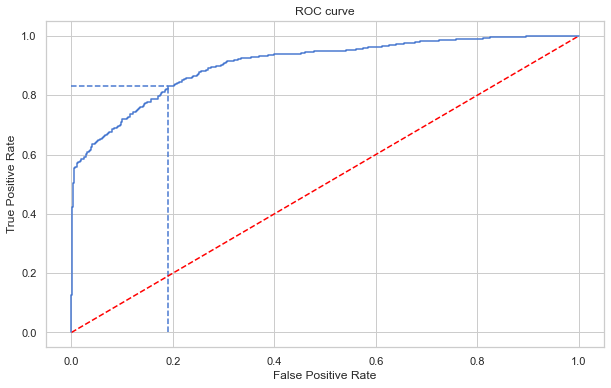

In [163]:
y_test_pred_prob = pd.DataFrame(cbc_mod.predict_proba(X_test)[:, 1])

fpr, tpr, best_threshold_ind, best_threshold = get_roc_curve(y_test, y_test_pred_prob)
roc_curves['CatBoostClassifier'] = (fpr, tpr, best_threshold_ind)
plot_roc_curve(fpr, tpr, best_threshold_ind)

In [164]:
y_test_pred = y_test_pred_prob.applymap(lambda x: 1 if x > best_threshold else 0)
y_test_pred
print('ACC with threshold', round(best_threshold, 3), '=', round(accuracy_score(y_test, y_test_pred) *100, 5))

ACC with threshold 0.514 = 82.00115


In [138]:
cbc_mod_all = CatBoostClassifier(n_estimators=500, learning_rate=0.05, max_depth=5) #var1 BEST!!!!!

# cbc_mod_all = CatBoostClassifier(n_estimators=400, learning_rate=0.05, max_depth=5) #var1
# cbc_mod_all = CatBoostClassifier(n_estimators=100, learning_rate=0.01, max_depth=8) #var2 schlechter als var1
# {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100}
cbc_mod_all.fit(X, y)

0:	learn: 0.6717874	total: 155ms	remaining: 1m 17s
1:	learn: 0.6559842	total: 173ms	remaining: 43s
2:	learn: 0.6367799	total: 187ms	remaining: 30.9s
3:	learn: 0.6200010	total: 198ms	remaining: 24.5s
4:	learn: 0.6064843	total: 208ms	remaining: 20.6s
5:	learn: 0.5948458	total: 219ms	remaining: 18.1s
6:	learn: 0.5826048	total: 230ms	remaining: 16.2s
7:	learn: 0.5731577	total: 240ms	remaining: 14.8s
8:	learn: 0.5623133	total: 251ms	remaining: 13.7s
9:	learn: 0.5545097	total: 262ms	remaining: 12.8s
10:	learn: 0.5472332	total: 273ms	remaining: 12.1s
11:	learn: 0.5385575	total: 279ms	remaining: 11.3s
12:	learn: 0.5294170	total: 285ms	remaining: 10.7s
13:	learn: 0.5247190	total: 291ms	remaining: 10.1s
14:	learn: 0.5201200	total: 298ms	remaining: 9.62s
15:	learn: 0.5147651	total: 304ms	remaining: 9.18s
16:	learn: 0.5105125	total: 308ms	remaining: 8.76s
17:	learn: 0.5040928	total: 313ms	remaining: 8.39s
18:	learn: 0.5005915	total: 318ms	remaining: 8.06s
19:	learn: 0.4967769	total: 323ms	remainin

186:	learn: 0.3696283	total: 1.24s	remaining: 2.08s
187:	learn: 0.3693550	total: 1.25s	remaining: 2.07s
188:	learn: 0.3690319	total: 1.25s	remaining: 2.06s
189:	learn: 0.3682774	total: 1.26s	remaining: 2.06s
190:	learn: 0.3679992	total: 1.27s	remaining: 2.05s
191:	learn: 0.3677669	total: 1.27s	remaining: 2.04s
192:	learn: 0.3675249	total: 1.28s	remaining: 2.03s
193:	learn: 0.3673423	total: 1.28s	remaining: 2.02s
194:	learn: 0.3670582	total: 1.29s	remaining: 2.02s
195:	learn: 0.3669404	total: 1.29s	remaining: 2.01s
196:	learn: 0.3667080	total: 1.3s	remaining: 2s
197:	learn: 0.3664691	total: 1.31s	remaining: 2s
198:	learn: 0.3661169	total: 1.31s	remaining: 1.99s
199:	learn: 0.3659451	total: 1.32s	remaining: 1.98s
200:	learn: 0.3657583	total: 1.32s	remaining: 1.97s
201:	learn: 0.3652941	total: 1.33s	remaining: 1.96s
202:	learn: 0.3647947	total: 1.34s	remaining: 1.96s
203:	learn: 0.3643225	total: 1.34s	remaining: 1.95s
204:	learn: 0.3640427	total: 1.35s	remaining: 1.94s
205:	learn: 0.36362

345:	learn: 0.3310123	total: 2.15s	remaining: 956ms
346:	learn: 0.3307587	total: 2.15s	remaining: 950ms
347:	learn: 0.3306501	total: 2.16s	remaining: 943ms
348:	learn: 0.3305040	total: 2.17s	remaining: 937ms
349:	learn: 0.3302769	total: 2.17s	remaining: 930ms
350:	learn: 0.3301224	total: 2.17s	remaining: 923ms
351:	learn: 0.3298410	total: 2.18s	remaining: 917ms
352:	learn: 0.3296548	total: 2.19s	remaining: 910ms
353:	learn: 0.3295131	total: 2.19s	remaining: 904ms
354:	learn: 0.3293504	total: 2.2s	remaining: 897ms
355:	learn: 0.3292069	total: 2.2s	remaining: 891ms
356:	learn: 0.3289952	total: 2.21s	remaining: 885ms
357:	learn: 0.3288391	total: 2.21s	remaining: 878ms
358:	learn: 0.3286493	total: 2.22s	remaining: 872ms
359:	learn: 0.3285106	total: 2.23s	remaining: 866ms
360:	learn: 0.3283324	total: 2.23s	remaining: 859ms
361:	learn: 0.3281583	total: 2.24s	remaining: 853ms
362:	learn: 0.3280513	total: 2.24s	remaining: 846ms
363:	learn: 0.3278389	total: 2.25s	remaining: 840ms
364:	learn: 0.

In [ ]:
y_pred_prob = pd.DataFrame(cbc_mod_all.predict_proba(X)[:, 1])

fpr, tpr, best_threshold_ind, best_threshold = get_roc_curve(y, y_pred_prob)

print(best_threshold)

## LGBMClassifier

In [165]:
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.5],
    "n_estimators": [50, 100, 150, 200, 250],
    'max_depth' : [3, 5, 8, 12]#,
 #   'min_samples_leaf' : [1, 3, 5, 8]
}


LGBMClassifier_gridsearch_hp_tuning = GridSearchCV(
        LGBMClassifier(),
        param_grid=param_grid,
      #  scoring="accuracy",
        n_jobs=-1,
        verbose = 2
)

LGBMClassifier_gridsearch_hp_tuning.fit(X_train, y_train)
print(LGBMClassifier_gridsearch_hp_tuning.best_params_)

print("best_score = ", LGBMClassifier_gridsearch_hp_tuning.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 100}
best_score =  0.8078813958179252


In [166]:
lgbmc_mod= LGBMClassifier(learning_rate = 0.05, max_depth = 12, n_estimators = 100)
lgbmc_mod.fit(X_train, y_train)

print('Acc Train =', round(lgbmc_mod.score(X_train, y_train) * 100, 2))
print('Acc Test =', round(lgbmc_mod.score(X_test, y_test) * 100, 2))

model_acc['LGBMClassifier'] = round(lgbmc_mod.score(X_test, y_test) * 100, 2)

Acc Train = 86.54
Acc Test = 81.08


tpr = 0.8315911730545877 fpr = 0.19020501138952164 threshold = 0.5136386270485045


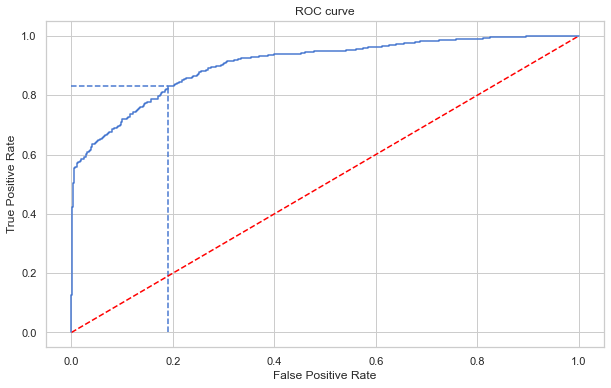

In [167]:
y_test_pred_prob = pd.DataFrame(cbc_mod.predict_proba(X_test)[:, 1])

fpr, tpr, best_threshold_ind, best_threshold = get_roc_curve(y_test, y_test_pred_prob)
roc_curves['LGBMClassifier'] = (fpr, tpr, best_threshold_ind)
plot_roc_curve(fpr, tpr, best_threshold_ind)

In [168]:
y_test_pred = y_test_pred_prob.applymap(lambda x: 1 if x > best_threshold else 0)
y_test_pred
print('ACC with threshold', round(best_threshold, 3), '=', round(accuracy_score(y_test, y_test_pred) *100, 5))

ACC with threshold 0.514 = 82.00115


In [ ]:
lgbmc_mod_all = CatBoostClassifier(n_estimators=100, learning_rate=0.05, max_depth=12) #var1
#{'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 100}

lgbmc_mod_all.fit(X, y)

## ROC PLOT

In [173]:
pd.Series(model_acc).sort_values()

KNeighborsClassifier          77.34
LogisticRegression            78.26
DecisionTreeClassifier        78.55
SVC                           80.05
GradientBoostingClassifier    80.62
RandomForestClassifier        80.68
LGBMClassifier                81.08
CatBoostClassifier            81.60
XGBClassifier                 82.06
dtype: float64

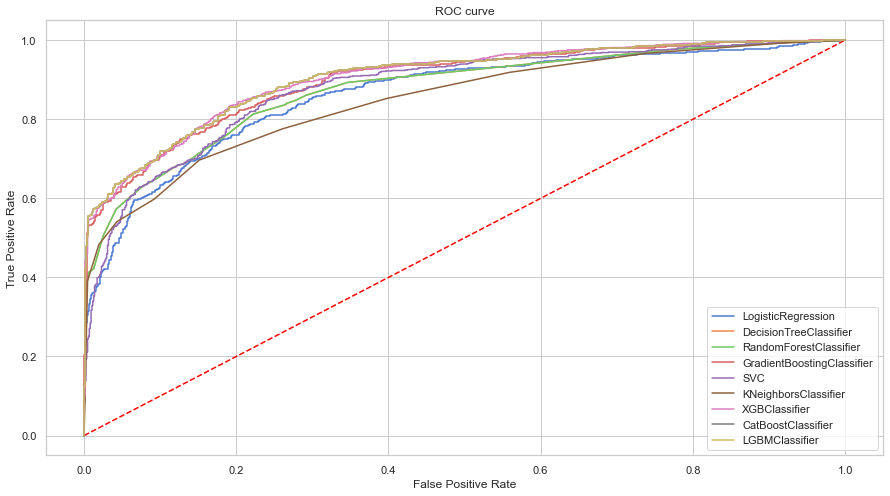

In [176]:
fig, axs = plt.subplots(figsize=(15, 8))
colors= []

plt.plot([0, 1], [0, 1], linestyle='dashed', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

for model in roc_curves.keys():
    plt.plot(roc_curves[model][0], roc_curves[model][1], label=model)
    axs.legend()



In [ ]:
roc_curves['DecisionTreeClassifier'][0]

## Final Forcast

In [139]:
validation_df = pd.read_csv("test.csv", sep=',', engine='python')
validation_df

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0013_01      Earth      True     G/3/S    TRAPPIST-1e  27.0  False   
1        0018_01      Earth     False     F/4/S    TRAPPIST-1e  19.0  False   
2        0019_01     Europa      True     C/0/S    55 Cancri e  31.0  False   
3        0021_01     Europa     False     C/1/S    TRAPPIST-1e  38.0  False   
4        0023_01      Earth     False     F/5/S    TRAPPIST-1e  20.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
4272     9266_02      Earth      True  G/1496/S    TRAPPIST-1e  34.0  False   
4273     9269_01      Earth     False       NaN    TRAPPIST-1e  42.0  False   
4274     9271_01       Mars      True   D/296/P    55 Cancri e   NaN  False   
4275     9273_01     Europa     False   D/297/P            NaN   NaN  False   
4276     9277_01      Earth      True  G/1498/S  PSO J318.5-22  43.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0             0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1             0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2             0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3             0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4            10.0        0.0         635.0     0.0     0.0   Brence Harperez  
...           ...        ...           ...     ...     ...               ...  
4272          0.0        0.0           0.0     0.0     0.0       Jeron Peter  
4273          0.0      847.0          17.0    10.0   144.0     Matty Scheron  
4274          0.0        0.0           0.0     0.0     0.0       Jayrin Pore  
4275          0.0     2680.0           0.0     0.0   523.0    Kitakan Conale  
4276          0.0        0.0           0.0     0.0     0.0  Lilace Leonzaley  

[4277 rows x 13 columns]

In [140]:
passengerId_df = validation_df.loc[:, ['PassengerId']]

validation_df, am, em = data_transform(validation_df, for_visual_df, age_medians_all, expenses_means_all)

validation_df = encode_data(validation_df, nominal_encoder_all, scaler_all)

validation_df = memory_optimiz(validation_df)

validation_df

------ HomePlanet_update ------------
HomePlanet NULLs: 87
1. (after replacement through the Сabin) HomePlanet NULLs: 87
2. (after replacement through the Deck) HomePlanet NULLs: 51
3. (after replacement through the LastName) HomePlanet NULLs: 9
4. (after replacement through the Destination): 0
5. (after replacement by the most common value) HomePlanet NULLs: 0
------ Destination_update ------------
Destination NULLs: 92
(after replacement by the most common value) Destination NULLs: 0
------ LastName_update ------------
LastName NULLs: 94
(3012, 2)
(after update) LastName NULLs: 51
namesakes_num_in_group NULLs: 51
namesakes_num_in_group NULLs: 0
------ CabinDeck_update ------------
CabinDeck NULLs: 100
(after update throw GroupId) CabinDeck NULLs: 63
(after update throw HomePlanet) CabinDeck NULLs: 0
------ CabinNum_update ------------
CabinNum NULLs: 100
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
A (1, 1)
B (11, 1)
C (6, 1)
D (1, 1)
E (2, 1)
F (25, 1)
G (54, 1)
CabinNum NULLs: 0
------

x0_Earth  x0_Europa  x0_Mars  x1_55 Cancri e  x1_PSO J318.5-22  \
0          1.0        0.0      0.0             0.0               0.0   
1          1.0        0.0      0.0             0.0               0.0   
2          0.0        1.0      0.0             1.0               0.0   
3          0.0        1.0      0.0             0.0               0.0   
4          1.0        0.0      0.0             0.0               0.0   
...        ...        ...      ...             ...               ...   
4272       1.0        0.0      0.0             0.0               0.0   
4273       1.0        0.0      0.0             0.0               0.0   
4274       0.0        0.0      1.0             1.0               0.0   
4275       0.0        1.0      0.0             0.0               0.0   
4276       1.0        0.0      0.0             0.0               1.0   

      x1_TRAPPIST-1e  x2_O  x2_P  x2_S  x3_A  ...   GroupId  NumInGroup  \
0                1.0   0.0   0.0   1.0   0.0  ...  0.001293    0.000000   
1                1.0   0.0   0.0   1.0   0.0  ...  0.001832    0.000000   
2                0.0   0.0   0.0   1.0   0.0  ...  0.001940    0.000000   
3                1.0   0.0   0.0   1.0   0.0  ...  0.002155    0.000000   
4                1.0   0.0   0.0   1.0   0.0  ...  0.002371    0.000000   
...              ...   ...   ...   ...   ...  ...       ...         ...   
4272             1.0   0.0   0.0   1.0   0.0  ...  0.998491    0.142857   
4273             1.0   1.0   0.0   0.0   0.0  ...  0.998815    0.000000   
4274             0.0   0.0   1.0   0.0   0.0  ...  0.999030    0.000000   
4275             1.0   0.0   1.0   0.0   0.0  ...  0.999246    0.000000   
4276             0.0   0.0   0.0   1.0   0.0  ...  0.999677    0.000000   

      CabinNum  IsChild  TotalSpend  GroupSize  IsSingle  \
0     0.003082      0.0    0.000000   0.000000       1.0   
1     0.003610      0.0    0.258001   0.000000       1.0   
2     0.001501      0.0    0.000000   0.000000       1.0   
3     0.002028      0.0    0.513060   0.000000       1.0   
4     0.004137      0.0    0.222872   0.000000       1.0   
...        ...      ...         ...        ...       ...   
4272  0.790178      0.0    0.000000   0.142857       0.0   
4273  0.793238      0.0    0.428165   0.000000       1.0   
4274  0.157549      0.0    0.000000   0.000000       1.0   
4275  0.158076      0.0    0.356356   0.000000       1.0   
4276  0.791232      0.0    0.000000   0.000000       1.0   

      namesakes_num_in_group  NameLength  NoSpend  
0                   0.000000    0.833333      1.0  
1                   0.000000    0.777778      0.0  
2                   0.000000    0.833333      1.0  
3                   0.000000    0.888889      0.0  
4                   0.000000    0.833333      0.0  
...                      ...         ...      ...  
4272                0.142857    0.611111      1.0  
4273                0.000000    0.722222      0.0  
4274                0.000000    0.611111      1.0  
4275                0.000000    0.777778      0.0  
4276                0.000000    0.888889      1.0  

[4277 rows x 44 columns]

In [ ]:
# pca_model_90 = PCA(n_components=12)
# pca_model_90.fit(validation_df)

# validation_df_auto_reduced = pca_model_90.transform(validation_df)
# validation_df_auto_reduced.shape
# validation_df_auto_reduced = pd.DataFrame(validation_df_auto_reduced)

# validation_df_pca = pd.concat((validation_df, validation_df_auto_reduced), axis=1)

In [141]:
y_val_pred_prob = pd.DataFrame(cbc_mod_all.predict_proba(validation_df)[:, 1])

#  y_val_pred = lgbmc_mod_all.predict(validation_df_pca)

# y_val_pred = lgbmc_mod_all.predict(validation_df)


#########y_val_pred = y_val_pred_prob.applymap(lambda x: x > 0.47419098173462404)

# y_val_pred = y_val_pred.astype(bool)
# y_val_pred

Text(0.5, 0, 'Predicted Propabilities')

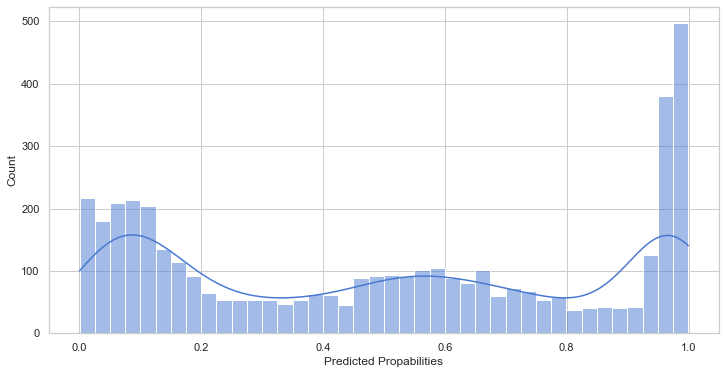

In [142]:
fig, axs = plt.subplots(figsize=(12, 6))
sns.histplot( x=y_val_pred_prob.loc[:, 0], bins=40, kde=True)

plt.xlabel('Predicted Propabilities')

In [143]:
# der Prozentsatz der transportierten Passagiere im ursprünglichen Datensatz
transported_prc = y.value_counts(normalize=True)[1]
print('Transported % = ', transported_prc)

thresholds = np.linspace(0, 1, num=200, endpoint=False)

res = {}

for t in thresholds:
    tmp_y_val_pred = y_val_pred_prob.applymap(lambda x: x > t)
    
    res[t] = abs(tmp_y_val_pred.value_counts(normalize=True)[True] - transported_prc)
    
best_threshold = min(res, key=res.get)    
print('best_threshold =', best_threshold)

Transported % =  0.5036236051995858
best_threshold = 0.51


In [144]:
y_val_pred = y_val_pred_prob.applymap(lambda x: x > best_threshold)


In [145]:
passengerId_df['Transported'] = y_val_pred
passengerId_df

PassengerId  Transported
0        0013_01         True
1        0018_01        False
2        0019_01         True
3        0021_01         True
4        0023_01         True
...          ...          ...
4272     9266_02         True
4273     9269_01        False
4274     9271_01         True
4275     9273_01         True
4276     9277_01         True

[4277 rows x 2 columns]

In [146]:
passengerId_df.to_csv('sample_submission.csv', index=False)